<a href="https://colab.research.google.com/github/MilerDiazZevallos/Arequipa-Covid-19/blob/master/Sala_Situacional_Arequipa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import curve_fit

! pip install empiricaldist
from empiricaldist import Pmf, Cdf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for empiricaldist: filename=empiricaldist-0.3.9-cp36-none-any.whl size=10157 sha256=947ac63d68a3f623dbe11912750ad48a62c534bcd5bff98a0fea7bb281fc5833
  Stored in directory: /root/.cache/pip/wheels/bf/70/8c/55788f5a5806e6da295e5da80d2c0ef286d9a8260a1e3142e1
Successfully built empiricaldist


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# R Function
### References:
### https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

### https://medium.com/@rburhum/el-martillazo-y-el-huayno-278716f49938

In [ ]:
#@title
# general imports
import numpy as np
import datetime as dt

from joblib import Parallel, delayed

# matplotlib
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# scipy specifics
from scipy import stats as sps
from scipy.interpolate import interp1d

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
#print(len(r_t_range))
# best sigma for Perú (prior hyperparameters)
#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
#OPTIMAL_SIGMA = 0.01
OPTIMAL_SIGMA = 0.05

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

#@title
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()

    #print(smoothed_cases.to_csv('smoothed_cases'))

    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    #print(len(zeros))
    
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
        #print(last_zero)
        #print(idx_start)

    
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    #print(smoothed_cases.head())
    #print(original.head())

    #print('End smoothed')
    return original, smoothed_cases
    

def calculate_posteriors(sr, sigma=0.15):

    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # (1) Calculate Lambda
    #print(sr[:-1].tail())
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    #print('lam shape', lam.shape)
    
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    #print('likelihoods shape', likelihoods.shape)

    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    #print('process_matrix shape', process_matrix.shape)

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    #print('process_matrix shape', process_matrix.shape)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()
    #print('prior0 shape', prior0.shape)

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    #print('posteriors shape', posteriors.shape)
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    #print(sr.index[:-1])
    #print(sr.index[1:])
    
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood
    

def highest_density_interval(pmf, p=.9):

    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    #print(cumsum.shape)
    
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()

    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

    return interval
    

def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    ax.set_title(f"{state_name}")

    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    #ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=cmap(color_mapped(values)), edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-05-01'), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.25, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(pd.Timestamp('2020-05-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))

    for i,j in zip(index,values):
        if i in mondays:
            ax.annotate(str(round(j, 2)),xy=(i,j+0.1), arrowprops=dict(facecolor='black', shrink=0.05),) 

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """


    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.7,.7,.7],
                  ecolor=[.3,.3,.3],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)


    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)


    fig.set_facecolor('w')
    return fig, ax

def run_full_model(cases, sigma=OPTIMAL_SIGMA):
    # initializing result dict
    result = {''}

    # smoothing series
    new, smoothed = smooth_new_cases(cases)
    #smooth_new_cases(cases)

    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)
    #calculate_posteriors(smoothed, sigma=sigma)

    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)
    #highest_density_interval(posteriors, p=.9)

    return result

# Doubling-time Function
### References:
### https://github.com/COVID-19-AI-Research-Project/AI-Data-Analysis/blob/master/Projects/1/Prediction_Covid_19_WorldWide.ipynb

###### A large doubling time is good.
###### A constant doubling time - means the measures being taken are effective in controlling the spread
###### An increasing doubling time means - the battle is on winning side
###### A decreasing doubling time-- well danger zone ahead. Do something fast

### https://www.npr.org/sections/health-shots/2020/04/10/829167659/are-we-flattening-the-curve-states-keep-watch-on-coronavirus-doubling-times

In [ ]:
def prediction_country2(df1, tipo, plot=True):
    df_final = df1.copy()
    df_country = df_final
    df_country.reset_index(inplace=True)
    
    x=np.array(range(df_country.shape[0]))
    y=df_country[tipo].values
    #print(len(x))

    def func(x,a,b):
        return a*2**(x/b)

    def func1(x, a, b):
        return np.exp(b*(x-a))
  
  
    list_coeff = ['Arequipa']  
    for i in range(10, len(x)+1, 1):
        xdata = x[:i]
        ydata = y[:i]

        try:
            popt, pcov = curve_fit(func1,xdata=xdata,ydata=ydata)
        except:
            popt = np.array([0,0])
        
        #print(i, xdata, ydata, popt)
        popt_aux = popt[1]
        popt[1] = np.log(2.)/popt[1]
        list_coeff.append(popt)
  
    if plot:
        fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))

        #perc = np.diff(ydata) / ydata[:-1]
        #yfit = popt[0]*2**(xdata/popt[1])
        #perc_fit = np.diff(yfit) / yfit[:-1]

        #tdbl1 = np.log(2.)/popt[1]
        #print('popt1 =', popt, ', doubling time = {:.1f} days\n'.format(tdbl1))

        ax1.set_ylabel('Total infected in '+ 'Arequipa',fontsize=20)
        #ax1.set_yscale('log')
        ax1.plot(df_country[tipo],'--o',ms=10,label='Real Data')
        #ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
        ax1.plot(xdata,func1(xdata, popt[0], popt_aux),'-',label=f'Exponential fit np.exp({popt[1]}*(t-{popt[0]})), \n doubling time = {popt[1]} days')
        ax1.legend(fontsize=15)
        plt.show()

    return list_coeff

def get_country_double(df,country):
    df_coeff2 = df[country].str[-1]
    df_coeff1 = df[country].str[0]
    df_coeff2.dropna(inplace=True)
    df_coeff1.dropna(inplace=True)
    #df_coeff2 = np.log(2.)/df_coeff2.astype(str).astype(float)
    df_coeff2 = df_coeff2.astype(str).astype(float)
    df_coeff1 = df_coeff1.astype(str).astype(float)
    df_double = pd.concat([df_coeff1, df_coeff2], axis=1, join='outer')
    df_double.columns = ['Coeff1','Doubling Time in Days']
    return df_double

# Funciones Auxiliares

In [ ]:
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-11'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-05-25'), \
           pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-08'), pd.to_datetime('2020-06-15'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-06-29'), \
           pd.to_datetime('2020-07-06'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-20'), pd.to_datetime('2020-07-27'), \
           pd.to_datetime('2020-08-03'), pd.to_datetime('2020-08-08')]

In [ ]:
def plots(ax, type, data, labelx, labely, datax = '', datay = '', label = ''):
    if type == 'line_plt':
        ax.plot(data[datax],'--o',ms=10,label=labely)
        ax.plot(data[datax].rolling(7).mean(),'--o',ms=10,label=labely + ' promedio 7 días')
        ax.set_xlabel(labelx,fontsize=15)
    elif type == 'reg_sns':
        ax = sns.regplot(x=datax, y=datay, data=data, order=3, label=labely, ax=ax)
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    elif type == 'bar_sns':
        ax = sns.barplot(x=data.index, y=datay, data=data, ax=ax)
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    elif type == 'bar_stacked_plt':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    elif type == 'line_reg_stacked_sns':
        ax = sns.regplot(x=datax, y=datay+'_positivos', data=data, order=3, label=labely+' positivos', ax=ax)
        ax = sns.regplot(x=datax, y=datay+'_sospechosos', data=data, order=3, label=labely+' sospechosos', ax=ax)
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    ax.legend(fontsize=15)

# Load Data

In [ ]:
worksheet = gc.open('DatosArequipa').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
datos_arequipa_raw = pd.DataFrame.from_records(rows)

datos_arequipa_raw.columns = datos_arequipa_raw.iloc[0]

In [ ]:
datos_arequipa = datos_arequipa_raw.drop([0]).reset_index(drop=True)
display(datos_arequipa.tail())
display(datos_arequipa.shape)

,date,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades
95,2020-08-04,411395,55991,355398,6,1043,30209,430,349,42,16,358,623,12,41,9
96,2020-08-05,419850,58056,361769,25,1074,31771,438,339,39,18,369,642,12,41,10
97,2020-08-06,428864,60430,368410,24,1113,33184,421,296,46,12,394,656,12,41,10
98,2020-08-07,439007,62931,376057,19,1142,33382,449,338,40,20,404,675,12,41,10
99,2020-08-08,446570,64692,381834,44,1177,35145,474,298,40,23,415,699,12,41,10


(100, 16)

# Data Cleaning

In [ ]:
datos_arequipa['dia'] = datos_arequipa.index
datos_arequipa['date'] = pd.to_datetime(datos_arequipa['date'])
datos_arequipa['weekday'] = datos_arequipa['date'].dt.weekday
datos_arequipa['week'] = datos_arequipa['date'].dt.week
datos_arequipa['year'] = datos_arequipa['date'].dt.year
datos_arequipa.set_index('date', inplace=True)

In [ ]:
datos_arequipa.index

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24',
               '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
      

In [ ]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2020-05-01 to 2020-08-08
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   total_muestras              100 non-null    object
 1   casos_positivos             100 non-null    object
 2   casos_negativos             100 non-null    object
 3   espera_resultado            100 non-null    object
 4   defunciones                 100 non-null    object
 5   recuperados                 100 non-null    object
 6   hospitalizados_positivos    100 non-null    object
 7   hospitalizados_sospechosos  100 non-null    object
 8   uci_positivos               100 non-null    object
 9   uci_sospechosos             100 non-null    object
 10  defunciones_minsa           100 non-null    object
 11  defunciones_essalud         100 non-null    object
 12  defunciones_clinicas        100 non-null    object
 13  defunciones_domicilio       100

None

In [ ]:
for column in datos_arequipa.columns:
    datos_arequipa[column] = datos_arequipa[column].astype(int)

In [ ]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2020-05-01 to 2020-08-08
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   total_muestras              100 non-null    int64
 1   casos_positivos             100 non-null    int64
 2   casos_negativos             100 non-null    int64
 3   espera_resultado            100 non-null    int64
 4   defunciones                 100 non-null    int64
 5   recuperados                 100 non-null    int64
 6   hospitalizados_positivos    100 non-null    int64
 7   hospitalizados_sospechosos  100 non-null    int64
 8   uci_positivos               100 non-null    int64
 9   uci_sospechosos             100 non-null    int64
 10  defunciones_minsa           100 non-null    int64
 11  defunciones_essalud         100 non-null    int64
 12  defunciones_clinicas        100 non-null    int64
 13  defunciones_domicilio       100 non-null    in

None

# Data Pre-processing


In [ ]:
datos_arequipa['muestras_diarias'] = datos_arequipa['total_muestras'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['confirmados_diarios'] = datos_arequipa['casos_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['fallecidos_diarios'] = datos_arequipa['defunciones'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['recuperados_diarios'] = datos_arequipa['recuperados'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['hospitalizados_positivos_diarios'] = datos_arequipa['hospitalizados_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['uci_positivos_diarios'] = datos_arequipa['uci_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['positividad'] = (datos_arequipa['confirmados_diarios'] / datos_arequipa['muestras_diarias'] * 100).fillna(0).astype(int)
datos_arequipa['activos'] = datos_arequipa.casos_positivos - \
                            datos_arequipa.defunciones - \
                            datos_arequipa.recuperados 
datos_arequipa.tail()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,activos
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-04,411395,55991,355398,6,1043,30209,430,349,42,16,358,623,12,41,9,95,1,32,2020,7232,1935,35,1412,-19,-4,26,24739
2020-08-05,419850,58056,361769,25,1074,31771,438,339,39,18,369,642,12,41,10,96,2,32,2020,8455,2065,31,1562,8,-3,24,25211
2020-08-06,428864,60430,368410,24,1113,33184,421,296,46,12,394,656,12,41,10,97,3,32,2020,9014,2374,39,1413,-17,7,26,26133
2020-08-07,439007,62931,376057,19,1142,33382,449,338,40,20,404,675,12,41,10,98,4,32,2020,10143,2501,29,198,28,-6,24,28407
2020-08-08,446570,64692,381834,44,1177,35145,474,298,40,23,415,699,12,41,10,99,5,32,2020,7563,1761,35,1763,25,0,23,28370


# Plots - Test, Confirmados, Fallecidos

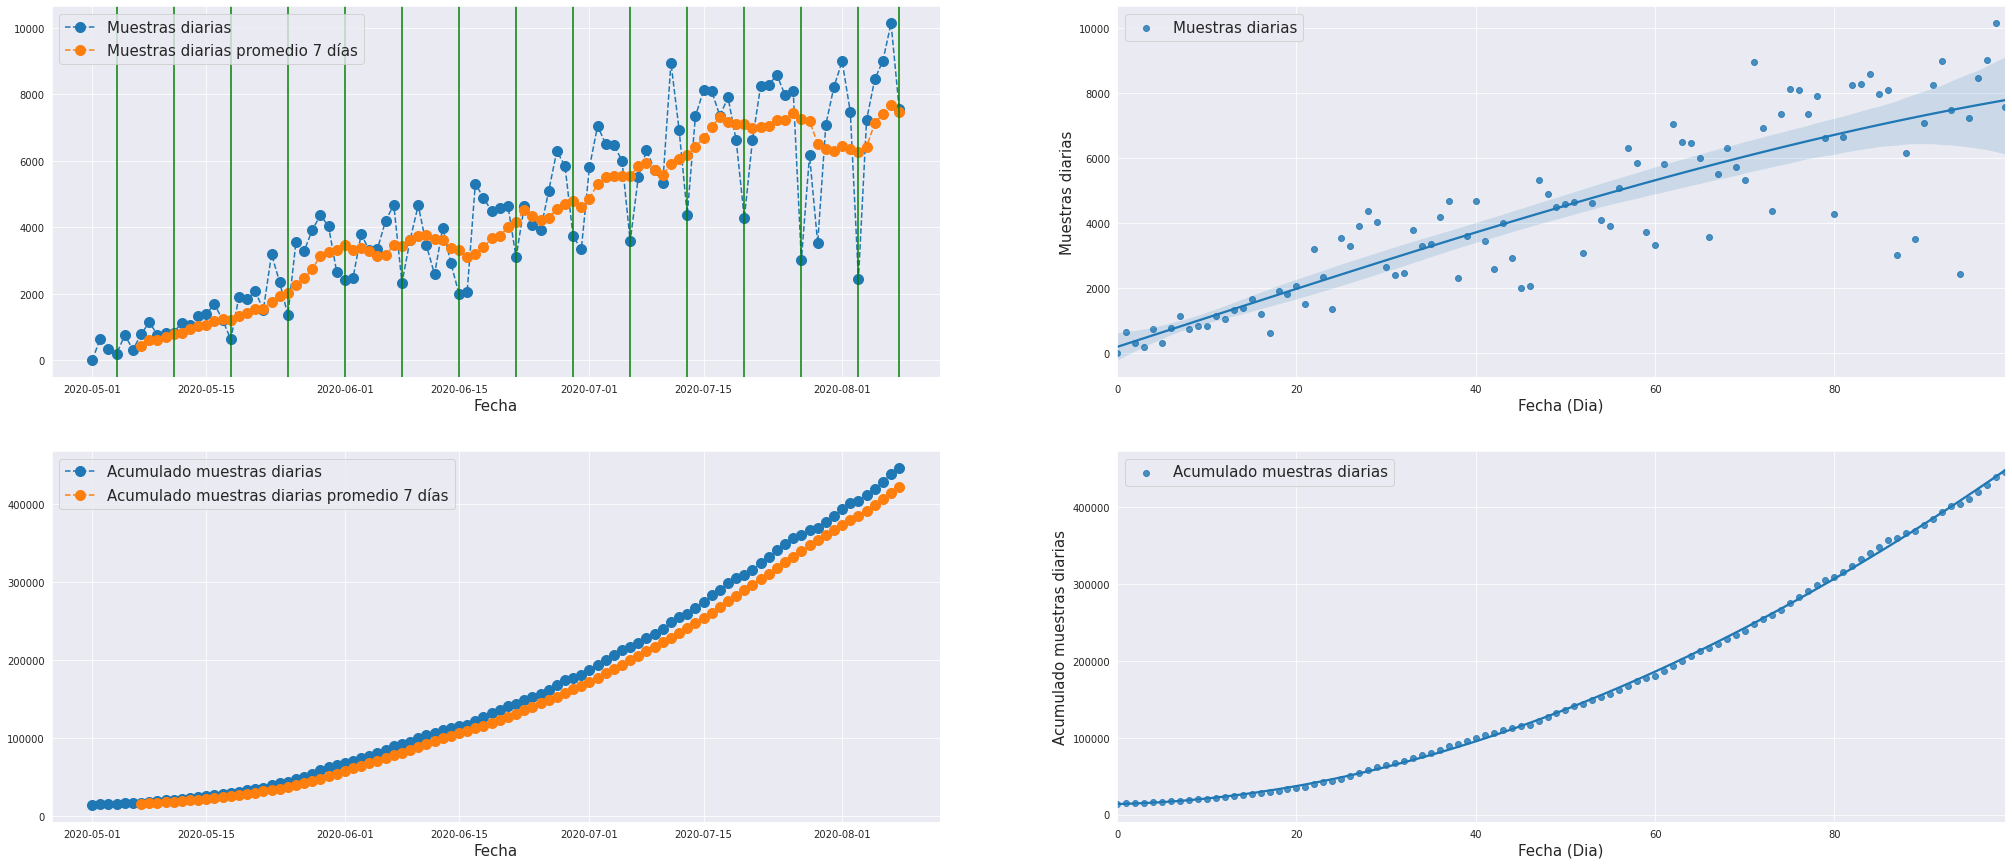

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Muestras diarias', 'muestras_diarias')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Muestras diarias', 'dia', 'muestras_diarias')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Acumulado muestras diarias', 'total_muestras')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Acumulado muestras diarias', 'dia', 'total_muestras')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_1.png')
plt.show()

***CONCLUSIONES: Se puede observar como el número de pruebas diarias esta aumentando, lo que en realidad es un factor positivo.***



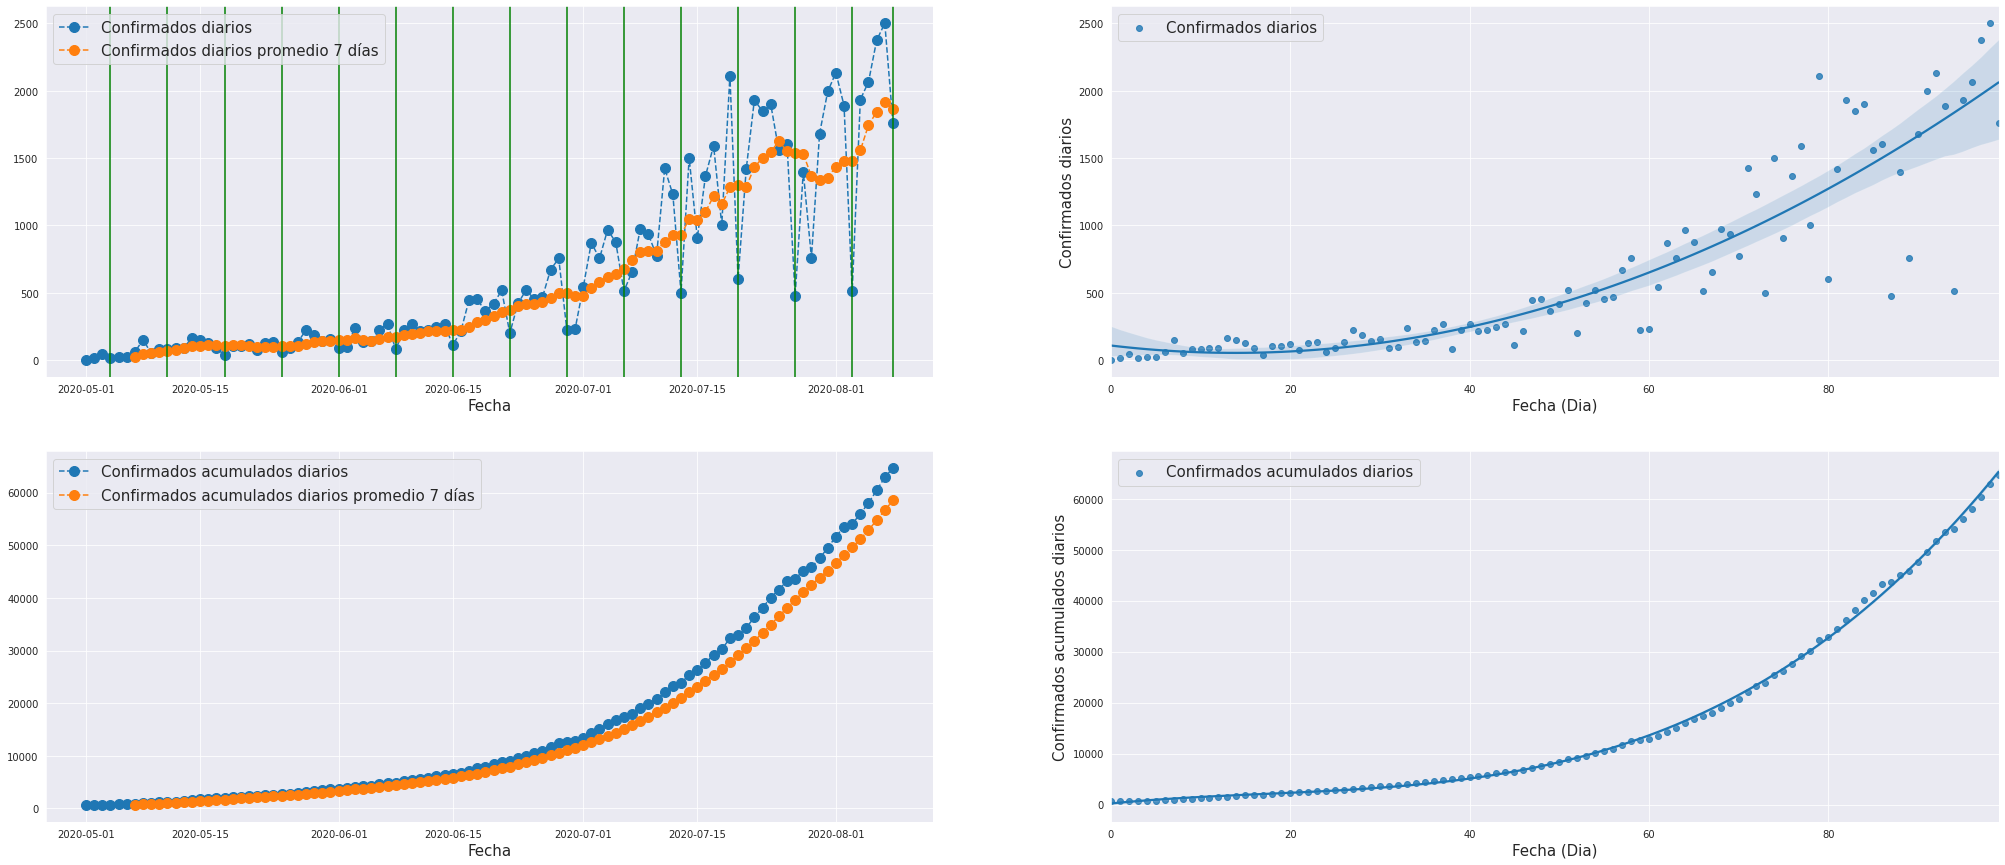

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados diarios', 'confirmados_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados diarios', 'dia', 'confirmados_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados acumulados diarios', 'casos_positivos')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados acumulados diarios', 'dia', 'casos_positivos')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_2.png')
plt.show()

***CONCLUSIONES: Se puede observar como el número de casos positivos también esta aumentando. Haciendo un análisis de regresión, la tendencia es que vaya en aumento.***

***Actualización(2020-07-28): La tendencia de los últimos días es que los contagios llegaron a estabilizarse.***

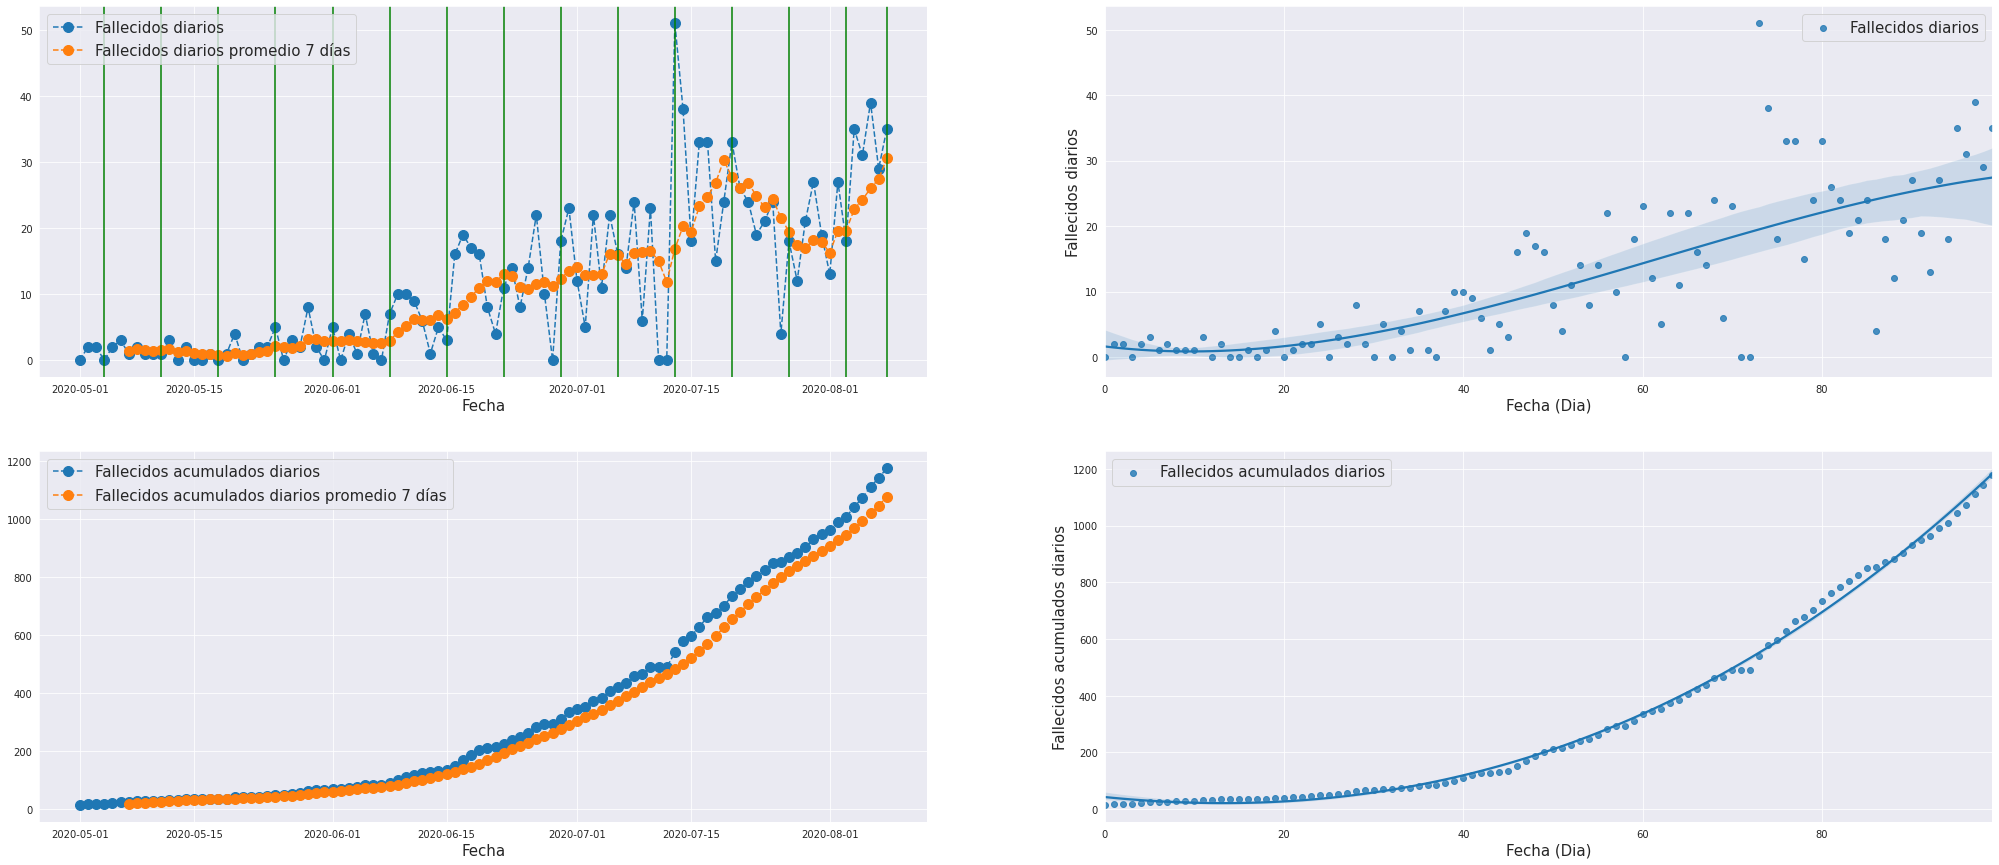

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos diarios', 'fallecidos_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos diarios', 'dia', 'fallecidos_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos acumulados diarios', 'defunciones')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos acumulados diarios', 'dia', 'defunciones')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_3.png')
plt.show()

***CONCLUSIONES: Se puede observar como el número de fatalidades también esta aumentando. Haciendo un análisis de regresión, la tendencia es que vaya en aumento pero la pendiente no es tan elevada.***

***Actualización(2020-07-28): El número de fallecidos esta disminuyendo diariamente.***

# Positividad

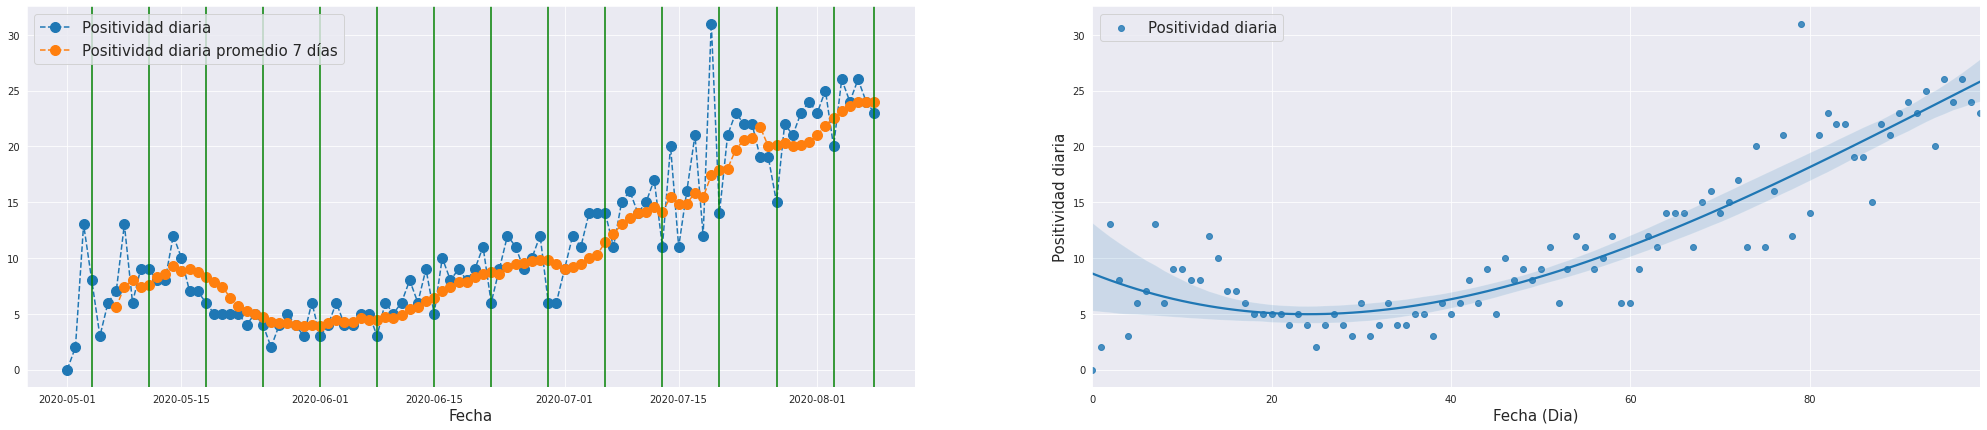

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Positividad diaria', 'positividad')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Positividad diaria', 'dia', 'positividad')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_4.png')
plt.show()

# Factor Salud - Hospitalizados y UCI

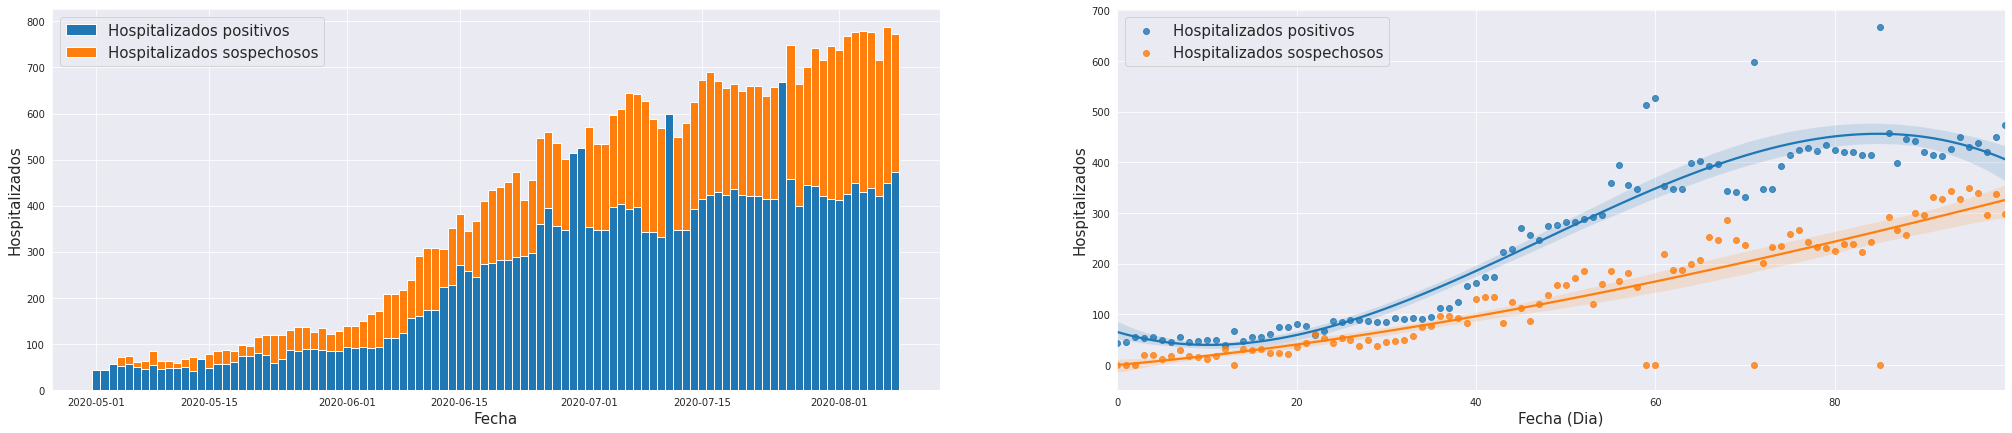

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))

plots(ax1, 'bar_stacked_plt', datos_arequipa, 'Fecha', 'Hospitalizados', 'index', 'hospitalizados')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'Hospitalizados', 'dia', 'hospitalizados')

plt.savefig('image_5.png')
plt.show()
plt.clf()


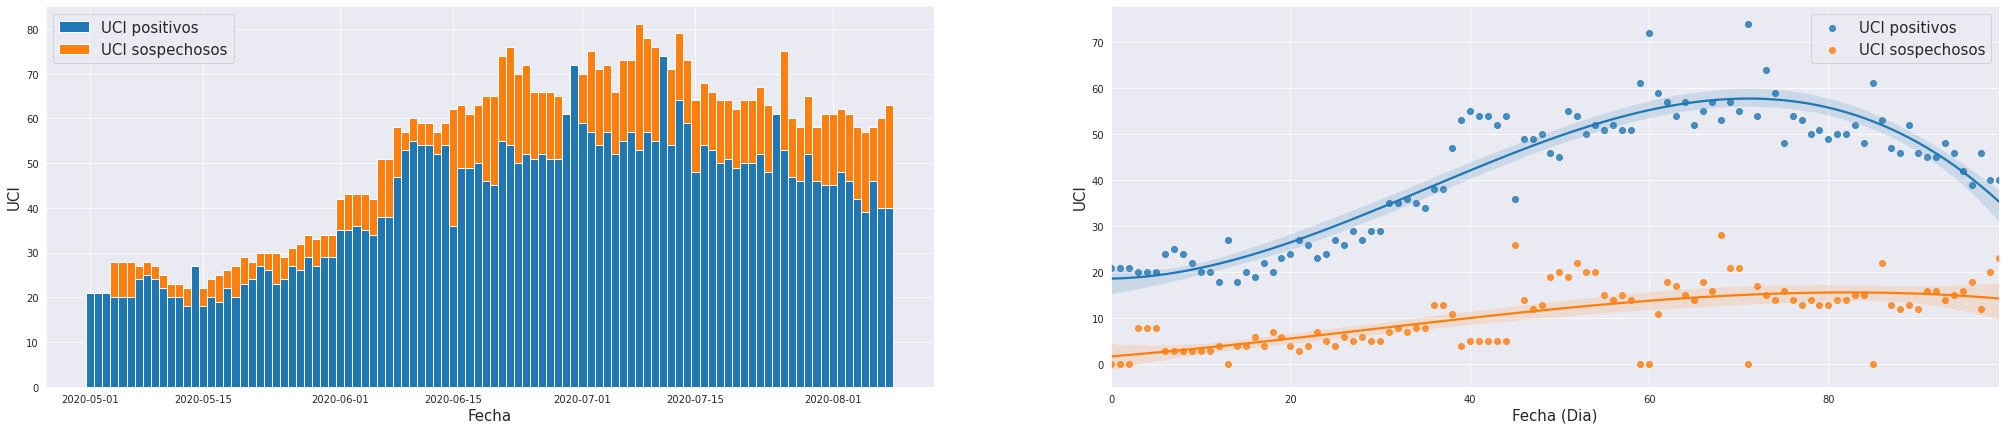

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))

plots(ax1, 'bar_stacked_plt', datos_arequipa, 'Fecha', 'UCI', 'index', 'uci')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'UCI', 'dia', 'uci')

plt.savefig('image_6.png')
plt.show()
plt.clf()

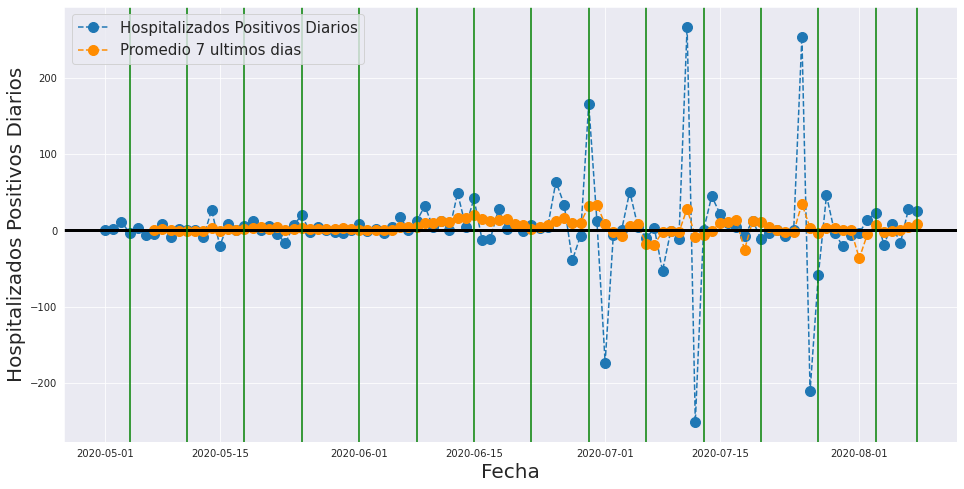

In [ ]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Hospitalizados Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'],'--o',ms=10,label='Hospitalizados Positivos Diarios')
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)

plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_7.png')
plt.show()

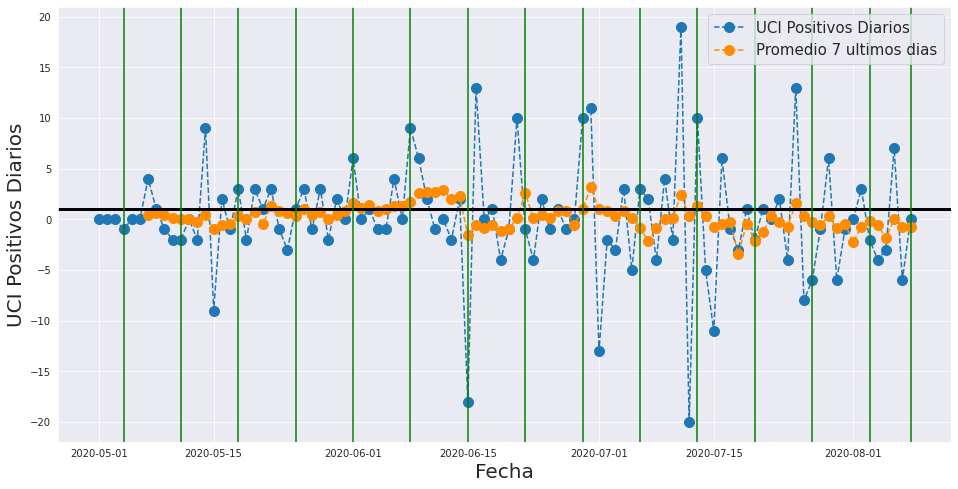

In [ ]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))

ax1.set_ylabel('UCI Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['uci_positivos_diarios'],'--o',ms=10,label='UCI Positivos Diarios')
ax1.plot(datos_arequipa['uci_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)

plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_8.png')
plt.show()

***CONCLUSIONES: Este es una de las principales métricas y se ve que la positividad va a aumentar y estará entre un 17 y 23% en las proximas semanas.***

***Actualización(2020-07-28): La positividad empezó a estabilizarse.***

# R Factor - Confirmados

In [ ]:
r_confirmados_arequipa = datos_arequipa.loc[:,['confirmados_diarios']]
r_confirmados_arequipa['state'] = 'AREQUIPA'
r_confirmados_arequipa = r_confirmados_arequipa.set_index([r_confirmados_arequipa.index, 'state'])
r_confirmados_arequipa = r_confirmados_arequipa['confirmados_diarios']
display(r_confirmados_arequipa)
r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.01)

date        state   
2020-05-01  AREQUIPA       0
2020-05-02  AREQUIPA      19
2020-05-03  AREQUIPA      45
2020-05-04  AREQUIPA      16
2020-05-05  AREQUIPA      26
                        ... 
2020-08-04  AREQUIPA    1935
2020-08-05  AREQUIPA    2065
2020-08-06  AREQUIPA    2374
2020-08-07  AREQUIPA    2501
2020-08-08  AREQUIPA    1761
Name: confirmados_diarios, Length: 100, dtype: int64

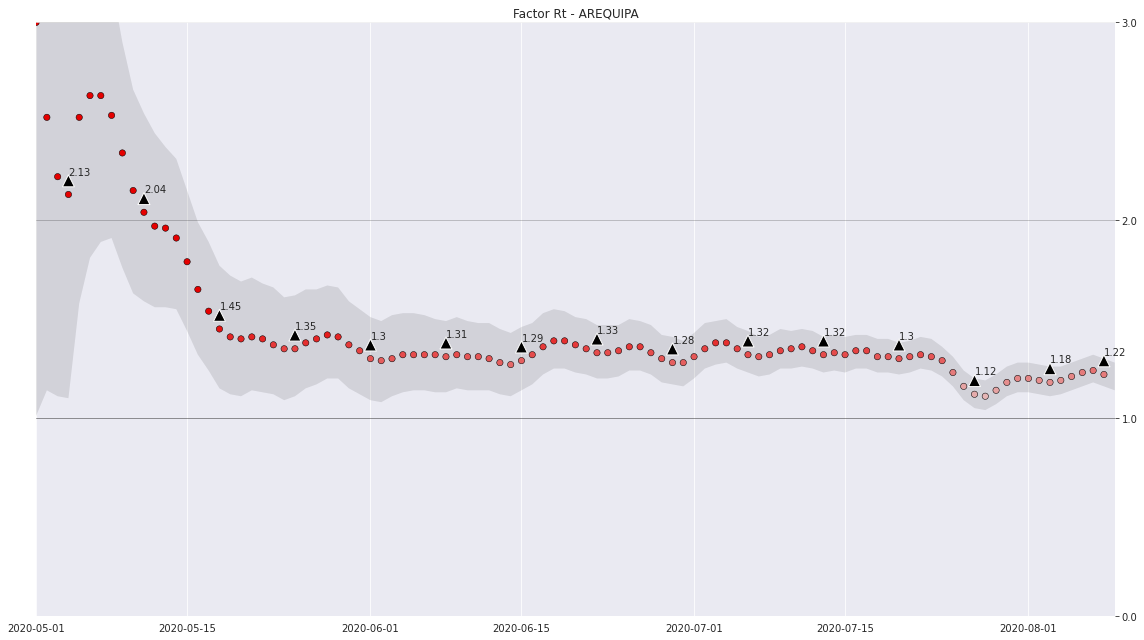

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_confirmados, ax, 'Factor Rt - AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.savefig('image_9.png')
plt.show()
plt.clf()

***CONCLUSIONES: Este es otra de las principales métricas y se ve que el Factor R se mantiene constante entre 1.3 y 1.4. Este dato es muy preocupante debido a que otros estudios realizados con los datos de todo el país, el tiempo para que este valor este por debajo de 1 es más de un mes. Esto indica a que los contagios no estaran controlados en mínimo un 1 hacia adelante.***

***Actualización(2020-07-28): El factor R esta disminuyendo rapidamente, esto es sumamente bueno.***

# R Factor - Fallecidos

In [ ]:
r_fallecidos_arequipa = datos_arequipa.loc[:,['fallecidos_diarios']]
r_fallecidos_arequipa['state'] = 'AREQUIPA'
r_fallecidos_arequipa = r_fallecidos_arequipa.set_index([r_fallecidos_arequipa.index, 'state'])
r_fallecidos_arequipa = r_fallecidos_arequipa['fallecidos_diarios']

r_fallecidos = run_full_model(r_fallecidos_arequipa, sigma=0.01)

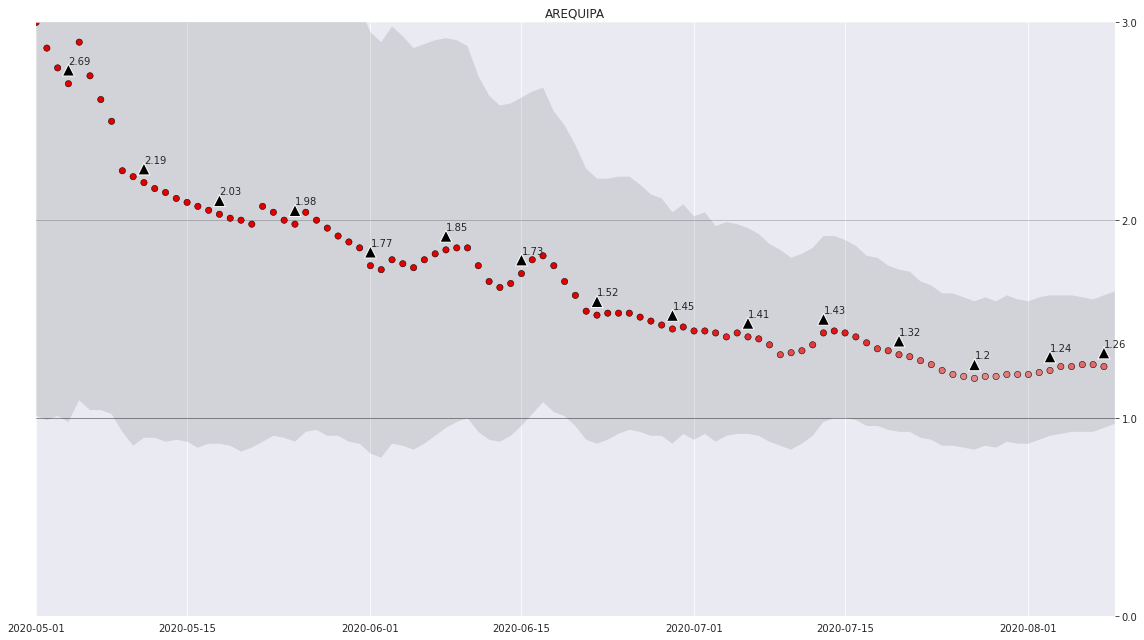

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_fallecidos, ax, 'AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()

# Plot doubling-time: Casos Positivos

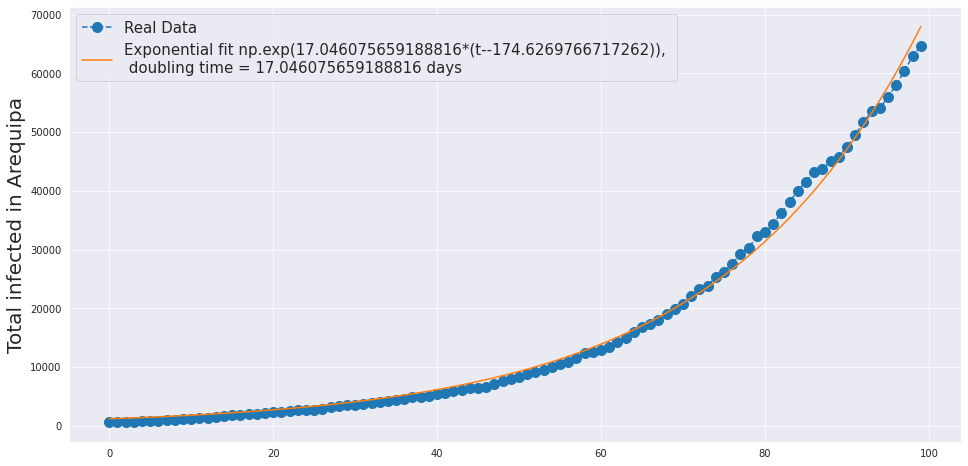

In [ ]:
List = []
coeff = prediction_country2(datos_arequipa,'casos_positivos',plot=True)
List.append(coeff)

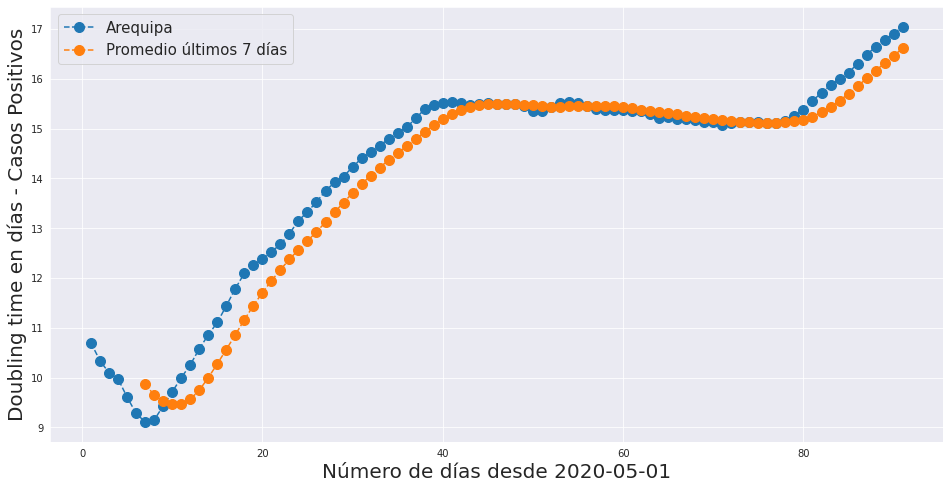

In [ ]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - Casos Positivos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
plt.savefig('image_10.png')
plt.show()

***CONCLUSIONES: Esta métrica mide el número de días que los contagios se duplicarán. Con los datos actuales de Arequipa se puede observar que los contagios se duplican cada 15 días. Mientras este valor aumente las medidas en que se están tomando son las adecuadas, pero el caso es totalmente contrario en Arequipa donde la tendencia es a disminuir.***

***Actualización(2020-07-28): Por fin se puede apreciar una tendencia a subir este factor, se espera mucho más.***

# Plot doubling-time: Fallecidos

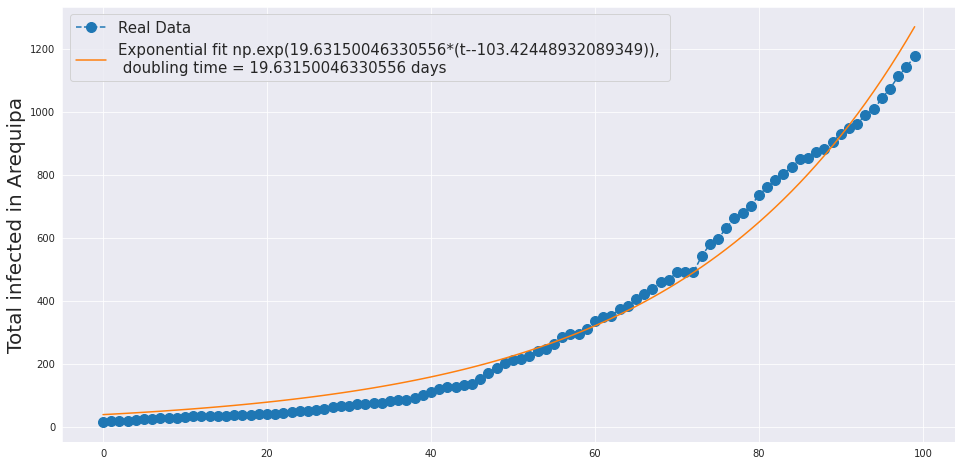

In [ ]:
List = []
coeff = prediction_country2(datos_arequipa,'defunciones',plot=True)
List.append(coeff)

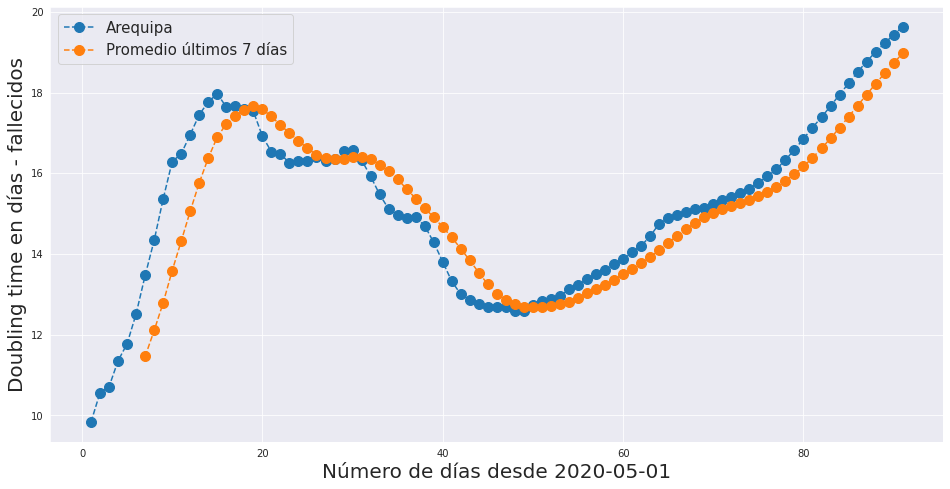

In [ ]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - fallecidos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
plt.savefig('image_11.png')
plt.show()

***CONCLUSIONES: Esta métrica mide el número de días que las fatalidades se duplicarán. Con los datos actuales de Arequipa se puede observar que las fatalidades se duplican también cada 15 días. Caso contrario a los contagios, la tendencia de esta métrica en las fatalidades esta aumentando y ese es un factor positivo.***

***Actualización(2020-07-28): Este factor en fallecidos pasó de 15 a 17 días, son excelentes noticias.***

# Plots - Defunciones, Activos, Recuperados

In [ ]:
data_map_arequipa = datos_arequipa.loc[:,['casos_positivos', 'defunciones','recuperados','activos','dia']]
data_map_arequipa['hito1'] = data_map_arequipa['defunciones']
data_map_arequipa['hito2'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos']
data_map_arequipa['hito3'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos'] + data_map_arequipa['recuperados']
data_map_arequipa.tail()

,casos_positivos,defunciones,recuperados,activos,dia,hito1,hito2,hito3
date,,,,,,,,
2020-08-04,55991,1043,30209,24739,95,1043,25782,55991
2020-08-05,58056,1074,31771,25211,96,1074,26285,58056
2020-08-06,60430,1113,33184,26133,97,1113,27246,60430
2020-08-07,62931,1142,33382,28407,98,1142,29549,62931
2020-08-08,64692,1177,35145,28370,99,1177,29547,64692


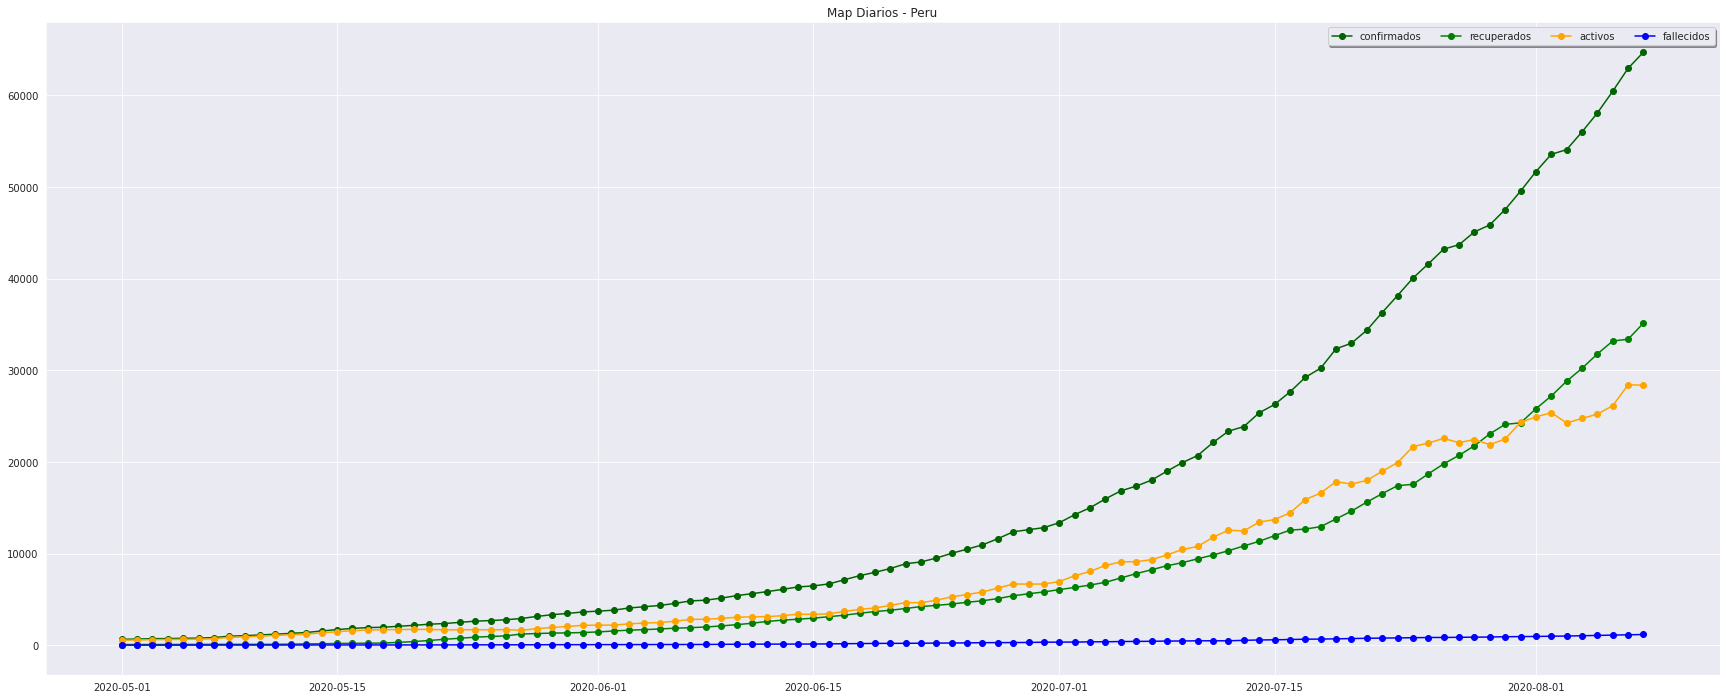

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

colors = ['darkgreen', 'green', 'orange', 'blue']
labels = ['confirmados', 'recuperados', 'activos', 'fallecidos']

ax1.plot_date(data_map_arequipa.index, data_map_arequipa['casos_positivos'], color=colors[0], label=labels[0], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['recuperados'], color=colors[1], label=labels[1], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['activos'], color=colors[2], label=labels[2], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['defunciones'], color=colors[3], label=labels[3], linestyle="-")

ax1.set(title='Map Diarios - Peru')

ax1.legend(fancybox=True, shadow=True, ncol=4)

plt.savefig('image_12.png')
plt.show()
plt.clf()

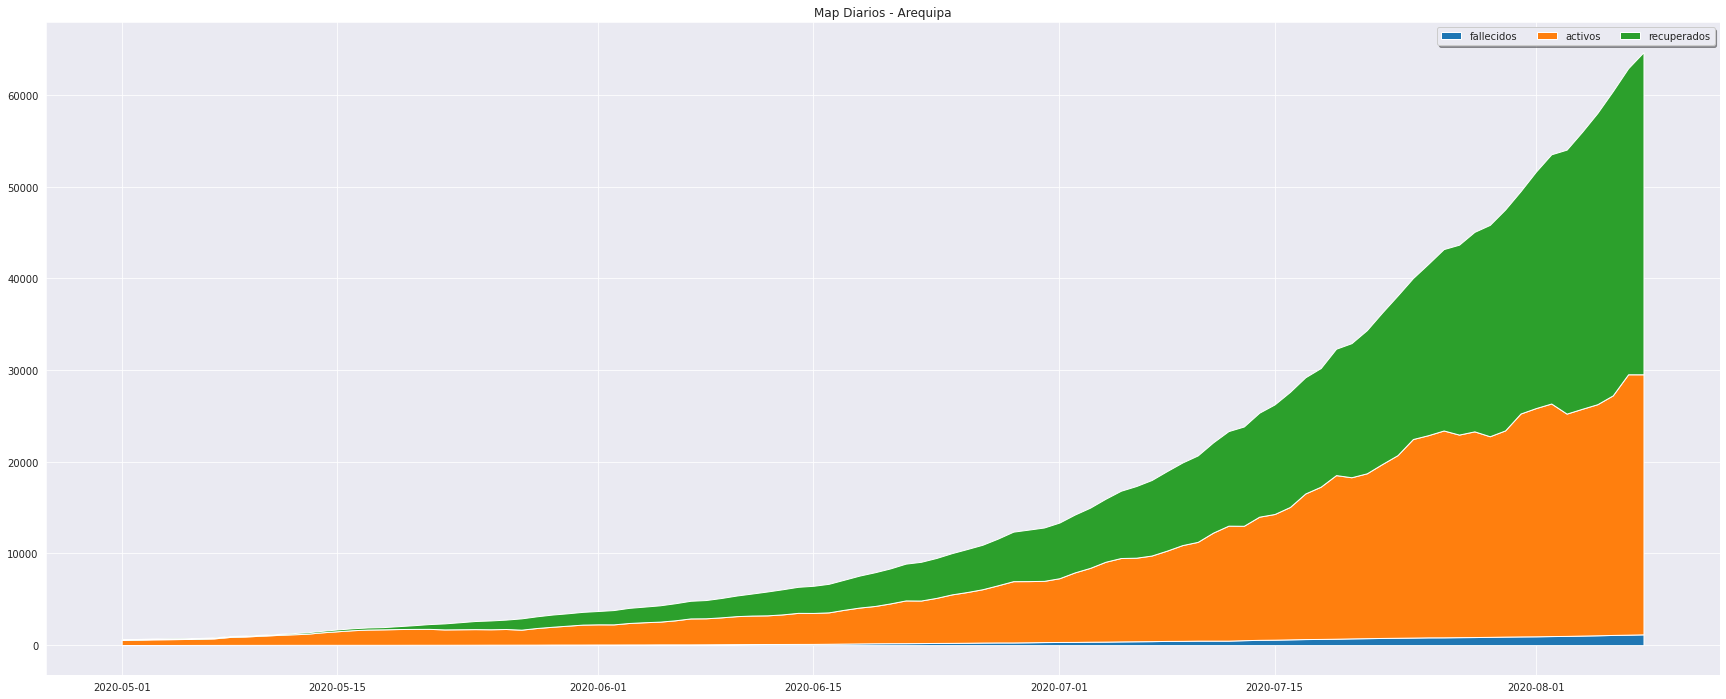

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

x1 = data_map_arequipa.index
x2 = data_map_arequipa['hito1']
x3 = data_map_arequipa['hito2']
x4 = data_map_arequipa['hito3']

ax1.fill_between(x1, 0, x2, label='fallecidos')
ax1.fill_between(x1, x2, x3, label='activos')
ax1.fill_between(x1, x3, x4, label='recuperados')

ax1.set(title='Map Diarios - Arequipa')

ax1.legend(fancybox=True, shadow=True, ncol=4)

plt.savefig('image_13.png')
plt.show()
plt.clf()

***CONCLUSIONES: En este gráfico se puede ver, que a diferencia de los datos de todo el Perú, el area de los activos son más que los recuperados.***

***Actualización(2020-07-28): Ya casi la cantidad de recuperados es el mismo a los contagiados. Esto no significa que todas las personas contagiadas ya están recuperadas, sino que el número de recuperadas acumuladas esta por alcanzar al número de personas contagiadas acumuladas.***

#Plots - Confirmados diarios vs Recuperados diarios

In [ ]:
daily_confirmados_vs_recuperados = datos_arequipa.loc[:,['confirmados_diarios','recuperados_diarios']]
daily_confirmados_vs_recuperados['diario_c_vs_r'] = daily_confirmados_vs_recuperados.recuperados_diarios / \
                                                    daily_confirmados_vs_recuperados.confirmados_diarios

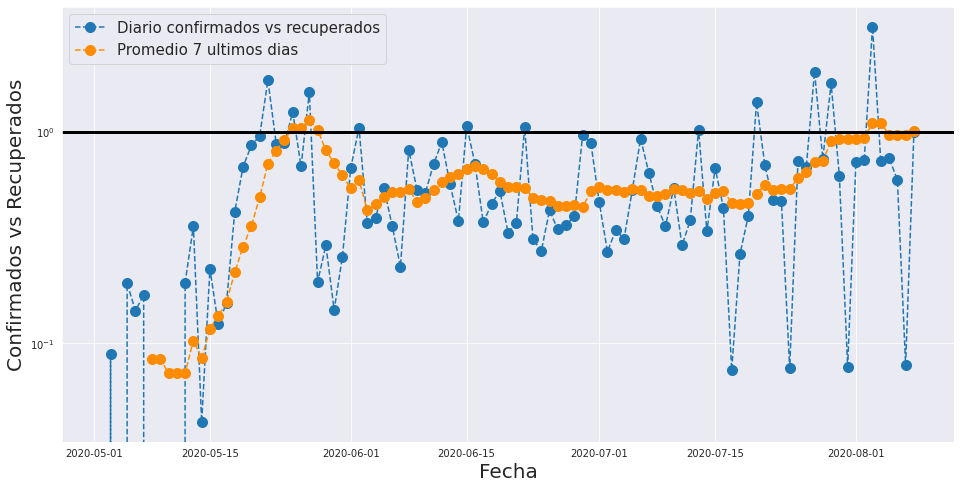

In [ ]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Confirmados vs Recuperados',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
#ax1.bar(daily_confirmados_vs_recuperados.index, daily_confirmados_vs_recuperados['diario_c_vs_r'],label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'],'--o',ms=10,label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
ax1.set_yscale('log')

plt.axhline(1, color='k',lw=3)

plt.savefig('image_14.png')
plt.show()

***CONCLUSIONES: En este gráfico se puede ver que solo entre el 20 y el 25 de Mayo la tasa de recuperados supero a la de contagiados, luego las tasa de recuperados es inferior a los contagiados.***

***Actualización(2020-07-28): El promedio de los últimos 7 días esta aumentando, que excelente.***

# SIR Function

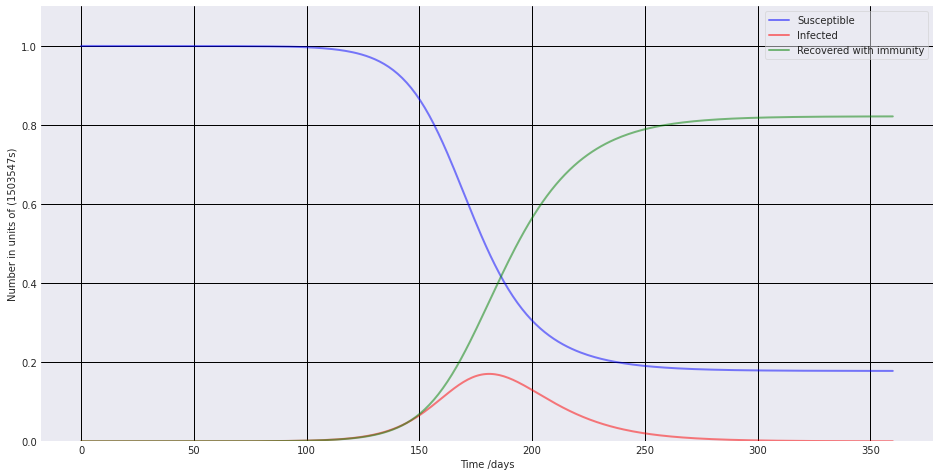

In [ ]:
from scipy.integrate import odeint

# Total population, Arequipa
N = 1503547
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.15, 1/14    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 360, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(16,8))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number in units of ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('image_15.png')
plt.show()

***CONCLUSIONES: Esta función grafíca el comportamiento del coronavirus con los datos de Arequipa. Los datos importantes son:***

1.   Poblacion de Arequipa: 1503547
2.   Contact rate (beta) : Diversos estudios catalogarón que en esta pandemia este valor se encontraría entre 0.2 y 0.3. (Se necesita mas investigación pero en caso del Perú un beta de 0.15 gráfica mejor la situación actual).
3.   Mean recovery rate (gamma): Básicamente este valor es 1/<Periodo de incubación>. Este dato para Perú es de 14 días.

Se puede observar que el límite de contagios en Arequipa llegaría en aproximadamente al día 170 y 180 que se inició la pandemia. Esto sería en un mes aproximadamente.

***Actualización(2020-07-28): Según todas las métricas, puede que se llegue al pico de contagiados algunas semanas antes de lo esperado.***


# Análisis por días de contagio


***Para realizar este estudio utilizaremos los datos del MINSA (Ministerio de Salud), recordando siempre que existen un deficit en el total de contagios reales vs reportados a esta institución***

In [ ]:
url = 'https://www.datosabiertos.gob.pe/node/6447/download/positivos_covid.csv'
#url = 'positivos_covid.csv'

datos_minsa = pd.read_csv(url, encoding = "ISO-8859-1") 

In [ ]:
# Si el archivo fue descargado ejecutar esta celda y comentar la tercera linea de la celda siguiente
########################################################################
datos_minsa.sort_values('FECHA_RESULTADO', inplace=True)
datos_minsa.dropna(inplace=True)
datos_minsa['FECHA_RESULTADO'] = datos_minsa['FECHA_RESULTADO'].astype(str)
datos_minsa.reset_index(drop=True, inplace=True)
datos_minsa['FECHA_RESULTADO'] = pd.to_datetime(datos_minsa['FECHA_RESULTADO'].apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8]))

In [ ]:
datos_minsa['EDAD'] = datos_minsa['EDAD'].fillna(0)
datos_minsa['EDAD'] = datos_minsa['EDAD'].astype('int')
#datos_minsa['FECHA_RESULTADO'] = pd.to_datetime(datos_minsa['FECHA_RESULTADO'], dayfirst=True)

datos_minsa = datos_minsa.apply(lambda x: x.str.upper() if x.dtype == "object" else x)  

In [ ]:
display(datos_minsa.info())
display(datos_minsa.sort_values('FECHA_RESULTADO'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463826 entries, 0 to 463825
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UUID             463826 non-null  object        
 1   DEPARTAMENTO     463826 non-null  object        
 2   PROVINCIA        463826 non-null  object        
 3   DISTRITO         463826 non-null  object        
 4   METODODX         463826 non-null  object        
 5   EDAD             463826 non-null  int64         
 6   SEXO             463826 non-null  object        
 7   FECHA_RESULTADO  463826 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 28.3+ MB


None

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
0,6E606FAAE5FFC2112CC7461B5E1AE34F,LIMA,LIMA,LA MOLINA,PCR,25,MASCULINO,2020-03-06
1,8262ABBC552DAA9CD466A8DF4D0E461A,AREQUIPA,AREQUIPA,AREQUIPA,PCR,29,MASCULINO,2020-03-07
2,0D2807A80BAFF7661A0D155CE09E4EA7,LIMA,LIMA,SANTIAGO DE SURCO,PCR,51,MASCULINO,2020-03-07
3,87ECFC43823C883B95CE9D8BA21776B6,LIMA,LIMA,SANTIAGO DE SURCO,PCR,74,FEMENINO,2020-03-07
4,66C48B4E09079803BE1F3080ED499F24,LIMA,LIMA,SANTIAGO DE SURCO,PCR,7,MASCULINO,2020-03-07
...,...,...,...,...,...,...,...,...
460835,E700C94081452685EBA5F93B5FB34209,LIMA,LIMA,SURQUILLO,PR,41,MASCULINO,2020-08-06
460834,CBE7BD784A42C4608AEE547A6937165D,AREQUIPA,AREQUIPA,PAUCARPATA,PR,34,FEMENINO,2020-08-06
460833,67B793F64745D2340A991ECE5F257728,AREQUIPA,AREQUIPA,PAUCARPATA,PR,39,FEMENINO,2020-08-06
460839,72637F33E89031E1F9C72CBA4BF8CADF,LIMA,LIMA,CARABAYLLO,PR,49,MASCULINO,2020-08-06


In [ ]:
datos_minsa_cut = datos_minsa.query('FECHA_RESULTADO >= \"2020-03-29\" & FECHA_RESULTADO <= \"2020-08-04\"')

In [ ]:
datos_minsa_cut = datos_minsa_cut.reset_index(drop=True)
display(datos_minsa_cut.info())
display(datos_minsa_cut.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451945 entries, 0 to 451944
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UUID             451945 non-null  object        
 1   DEPARTAMENTO     451945 non-null  object        
 2   PROVINCIA        451945 non-null  object        
 3   DISTRITO         451945 non-null  object        
 4   METODODX         451945 non-null  object        
 5   EDAD             451945 non-null  int64         
 6   SEXO             451945 non-null  object        
 7   FECHA_RESULTADO  451945 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 27.6+ MB


None

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
451940,24ECC4F2CD941D9D27F1FA977B6EF1E6,ANCASH,HUARAZ,HUARAZ,PR,57,MASCULINO,2020-08-04
451941,BE2496078B3225F9399D040924C6CA44,LIMA,LIMA,SAN JUAN DE MIRAFLORES,PCR,35,FEMENINO,2020-08-04
451942,08FE28565D16956708FE45FD94F28DB7,LIMA,LIMA,LIMA,PR,64,MASCULINO,2020-08-04
451943,3C5DDB2D815C06A54779C38261381408,LIMA,LIMA,JESUS MARIA,PR,76,MASCULINO,2020-08-04
451944,3189660892C6B9AFB57FC0BDB3429AE9,LIMA,LIMA,SAN JUAN DE LURIGANCHO,PCR,0,MASCULINO,2020-08-04


In [ ]:
display(datos_minsa_cut['FECHA_RESULTADO'].min())
display(datos_minsa_cut['FECHA_RESULTADO'].max())

Timestamp('2020-03-29 00:00:00')

Timestamp('2020-08-04 00:00:00')

In [ ]:
df_arequipa_dep = datos_minsa_cut[datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA']
df_arequipa_dep['WEEKDAY'] = df_arequipa_dep['FECHA_RESULTADO'].dt.weekday
df_arequipa_dep = df_arequipa_dep.reset_index(drop=True)
display(df_arequipa_dep.shape)
display(df_arequipa_dep.tail())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(16889, 9)

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO,WEEKDAY
16884,E8251DA20326A361F3A248C555B0203D,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,PR,46,MASCULINO,2020-08-04,1
16885,3E4DDCF9F9C49F9292F94B49EC757B04,AREQUIPA,AREQUIPA,PAUCARPATA,PR,41,MASCULINO,2020-08-04,1
16886,CF953DD53B9CF1CA444A43C1672E4D55,AREQUIPA,AREQUIPA,AREQUIPA,PR,26,FEMENINO,2020-08-04,1
16887,84BBBA4C24F94A8CB973F3C919B5C545,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,PR,53,FEMENINO,2020-08-04,1
16888,B6BE9035B4EAE4D7A505C7DE70C5CD67,AREQUIPA,AREQUIPA,PAUCARPATA,PR,56,MASCULINO,2020-08-04,1


PROVINCIA         SEXO     
AREQUIPA          MASCULINO    8430
                  FEMENINO     6597
CAYLLOMA          MASCULINO     297
ISLAY             MASCULINO     278
                  FEMENINO      271
CAYLLOMA          FEMENINO      242
CARAVELI          MASCULINO     144
CAMANA            MASCULINO     136
CARAVELI          FEMENINO      115
CAMANA            FEMENINO      103
CASTILLA          MASCULINO      76
EN INVESTIGACIÓN  MASCULINO      67
                  FEMENINO       48
CASTILLA          FEMENINO       44
CONDESUYOS        MASCULINO      16
LA UNION          MASCULINO      13
CONDESUYOS        FEMENINO        6
LA UNION          FEMENINO        6
Name: UUID, dtype: int64

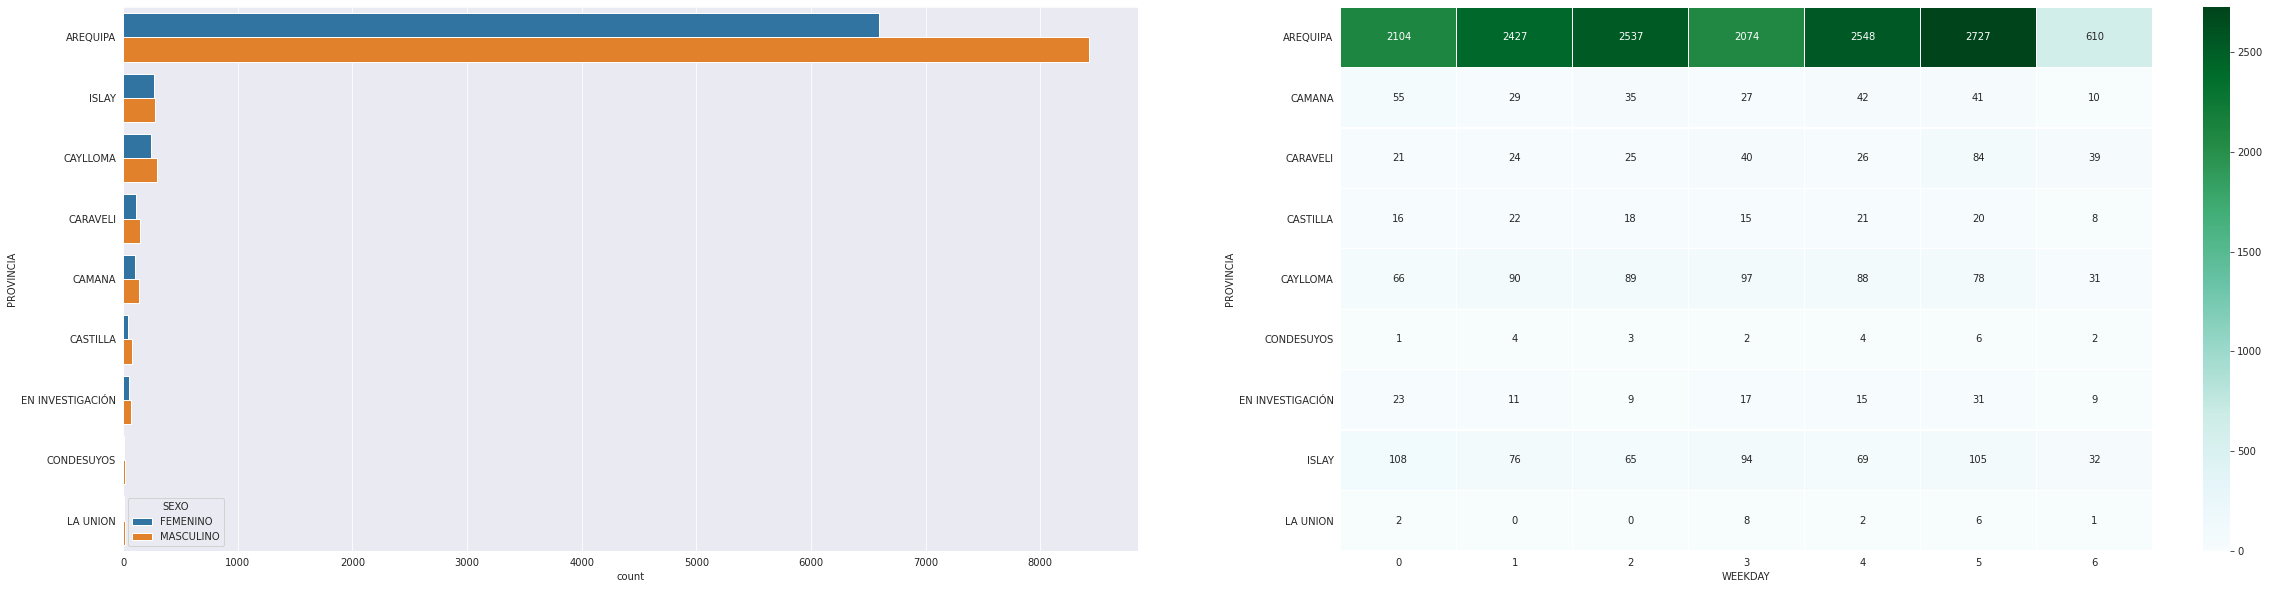

In [ ]:
pd_arequipa_dep_crosstab = pd.crosstab(df_arequipa_dep["PROVINCIA"], df_arequipa_dep["WEEKDAY"])

display(df_arequipa_dep.groupby(['PROVINCIA', 'SEXO'])['UUID'].count().sort_values(ascending=False))

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_dep, y='PROVINCIA', order = df_arequipa_dep['PROVINCIA'].value_counts().index, hue='SEXO', ax = ax1)
sns.heatmap(pd_arequipa_dep_crosstab, cmap="BuGn", linewidths=0.3, annot=True, fmt="d", ax = ax2)

plt.savefig('image_16.png')
plt.show()

In [ ]:
df_arequipa_pro = datos_minsa_cut[(datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA') & (datos_minsa_cut['PROVINCIA'] == 'AREQUIPA')].reset_index(drop=True)
df_arequipa_pro['WEEKDAY'] = df_arequipa_pro['FECHA_RESULTADO'].dt.weekday
display(df_arequipa_pro.shape)
display(df_arequipa_pro.tail())

(15027, 9)

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO,WEEKDAY
15022,E8251DA20326A361F3A248C555B0203D,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,PR,46,MASCULINO,2020-08-04,1
15023,3E4DDCF9F9C49F9292F94B49EC757B04,AREQUIPA,AREQUIPA,PAUCARPATA,PR,41,MASCULINO,2020-08-04,1
15024,CF953DD53B9CF1CA444A43C1672E4D55,AREQUIPA,AREQUIPA,AREQUIPA,PR,26,FEMENINO,2020-08-04,1
15025,84BBBA4C24F94A8CB973F3C919B5C545,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,PR,53,FEMENINO,2020-08-04,1
15026,B6BE9035B4EAE4D7A505C7DE70C5CD67,AREQUIPA,AREQUIPA,PAUCARPATA,PR,56,MASCULINO,2020-08-04,1


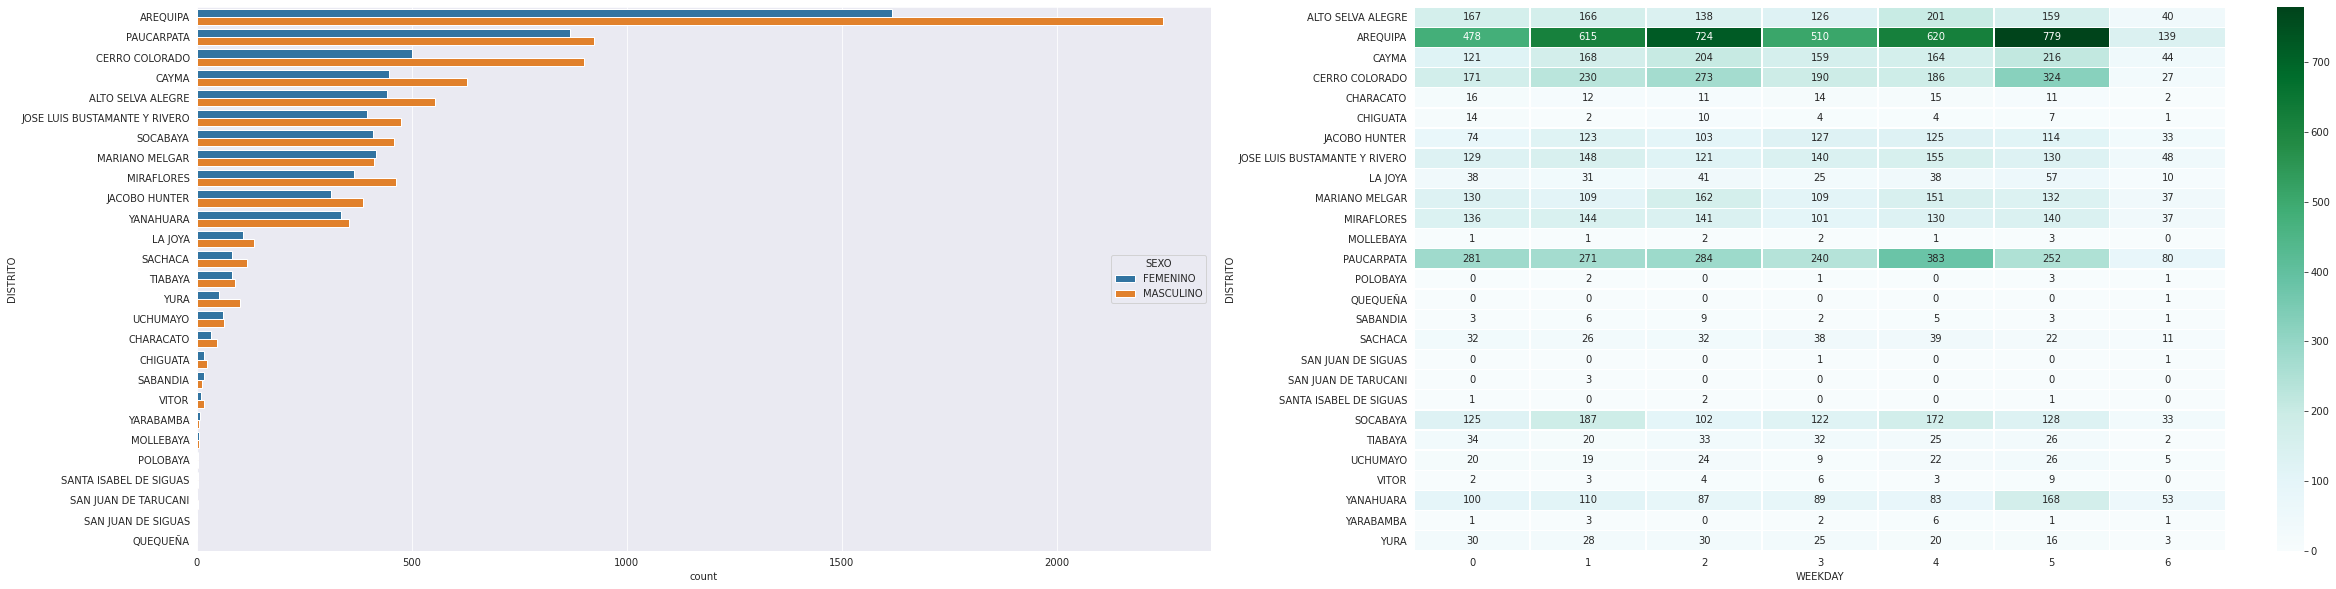

In [ ]:
pd_arequipa_pro_crosstab = pd.crosstab(df_arequipa_pro["DISTRITO"], df_arequipa_pro["WEEKDAY"])

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_pro, y='DISTRITO', order = df_arequipa_pro['DISTRITO'].value_counts().index, hue = 'SEXO', ax = ax1)
sns.heatmap(pd_arequipa_pro_crosstab, cmap="BuGn", linewidths=0.3, annot=True, fmt="d", ax = ax2)

plt.savefig('image_17.png')
plt.show()

***CONCLUSIONES: Esta, aunque no parezca, es una métrica importante; indica, aproximadamente, cuando es que las personas de Arequipa contraen el virus. Según la OMS, el virus tiende a provocar sintomas entre 5 y 6 días después de la exposición (pero pude variar entre 1 y 14 días), debido a la actual realidad de Arequipa (la temporada de invierno), en este estudio se cree que los sintomas tienden a aparecer lo mas antes posible (5 días).***

***Como vemos en las gráficas, los días (dentro de la provincia de Arequipa), más personas son diagnosticadas con COVID-19 son los MIERCOLES y SABADOS, si a estos días le quitamos los 5 días que demoraría una persona normal en tener los sintomas, eso quiere decir que las personas tienden a contagiarse más los días SABADOS y MARTES. SE SUGIERE A LAS PERSONAS NO SALIR LOS DIAS SABADO, LUNES Y MARTES***

***Referencia : https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/naming-the-coronavirus-disease-(covid-2019)-and-the-virus-that-causes-it***

***Tenemos que notar que los datos para esta métrica son extraídos de los datos liberados del MINSA.***

In [ ]:
df_arequipa_pro

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO,WEEKDAY
0,7F6BA4170863CFC4D6AC1BB87386DC95,AREQUIPA,AREQUIPA,AREQUIPA,PCR,30,FEMENINO,2020-03-29,6
1,AC03BA3CE3427B84F64EAC8A07547A8C,AREQUIPA,AREQUIPA,AREQUIPA,PCR,22,MASCULINO,2020-03-29,6
2,CD03B2C828400FA97205269C92C424D9,AREQUIPA,AREQUIPA,AREQUIPA,PCR,42,FEMENINO,2020-03-29,6
3,F996F49DFA191C986B6DFBA8052487D7,AREQUIPA,AREQUIPA,PAUCARPATA,PCR,67,MASCULINO,2020-03-29,6
4,BE2E951AA6D9CA399731BC7BC1C6FDA0,AREQUIPA,AREQUIPA,AREQUIPA,PCR,89,MASCULINO,2020-03-29,6
...,...,...,...,...,...,...,...,...,...
15022,E8251DA20326A361F3A248C555B0203D,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,PR,46,MASCULINO,2020-08-04,1
15023,3E4DDCF9F9C49F9292F94B49EC757B04,AREQUIPA,AREQUIPA,PAUCARPATA,PR,41,MASCULINO,2020-08-04,1
15024,CF953DD53B9CF1CA444A43C1672E4D55,AREQUIPA,AREQUIPA,AREQUIPA,PR,26,FEMENINO,2020-08-04,1
15025,84BBBA4C24F94A8CB973F3C919B5C545,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,PR,53,FEMENINO,2020-08-04,1


# Análisis por etapas y edad de las personas

In [ ]:
df_arequipa_pro['ETAPA'] = df_arequipa_pro['EDAD'].apply(lambda x: 
                              'INFANCIA(0-6)' if x <= 6 
                              else 'NIÑEZ(7-12)' if x <= 12 
                              else 'ADOLESCENCIA(13-20)' if x <= 20
                              else 'JUVENTUD(21-25)' if x <= 25
                              #else 'ADULTEZ_JOVEN' if x <= 40
                              #else 'ADULTEZ_INTERMEDIA' if x <= 50
                              #else 'ADULTEZ_TARDIA' if x <= 60 
                              else 'ADULTEZ(26-60)' if x <= 60 
                              else 'ANCIANIDAD(60+)') 

In [ ]:
df_etapas = df_arequipa_pro.groupby(['ETAPA', 'FECHA_RESULTADO']).size().reset_index().pivot(columns='ETAPA', index='FECHA_RESULTADO', values=0)
df_etapas.fillna(0, inplace=True)
df_etapas = df_etapas[['INFANCIA(0-6)', 'NIÑEZ(7-12)', 'ADOLESCENCIA(13-20)', 'JUVENTUD(21-25)', 'ADULTEZ(26-60)', 'ANCIANIDAD(60+)']]
df_etapas

ETAPA,INFANCIA(0-6),NIÑEZ(7-12),ADOLESCENCIA(13-20),JUVENTUD(21-25),ADULTEZ(26-60),ANCIANIDAD(60+)
FECHA_RESULTADO,,,,,,
2020-03-29,0.0,1.0,0.0,1.0,2.0,2.0
2020-03-30,0.0,0.0,0.0,0.0,2.0,3.0
2020-03-31,0.0,0.0,0.0,0.0,3.0,0.0
2020-04-02,0.0,0.0,0.0,1.0,1.0,4.0
2020-04-04,0.0,1.0,1.0,1.0,10.0,1.0
...,...,...,...,...,...,...
2020-07-31,3.0,3.0,37.0,33.0,388.0,99.0
2020-08-01,3.0,3.0,22.0,34.0,379.0,105.0
2020-08-02,0.0,1.0,4.0,5.0,36.0,15.0


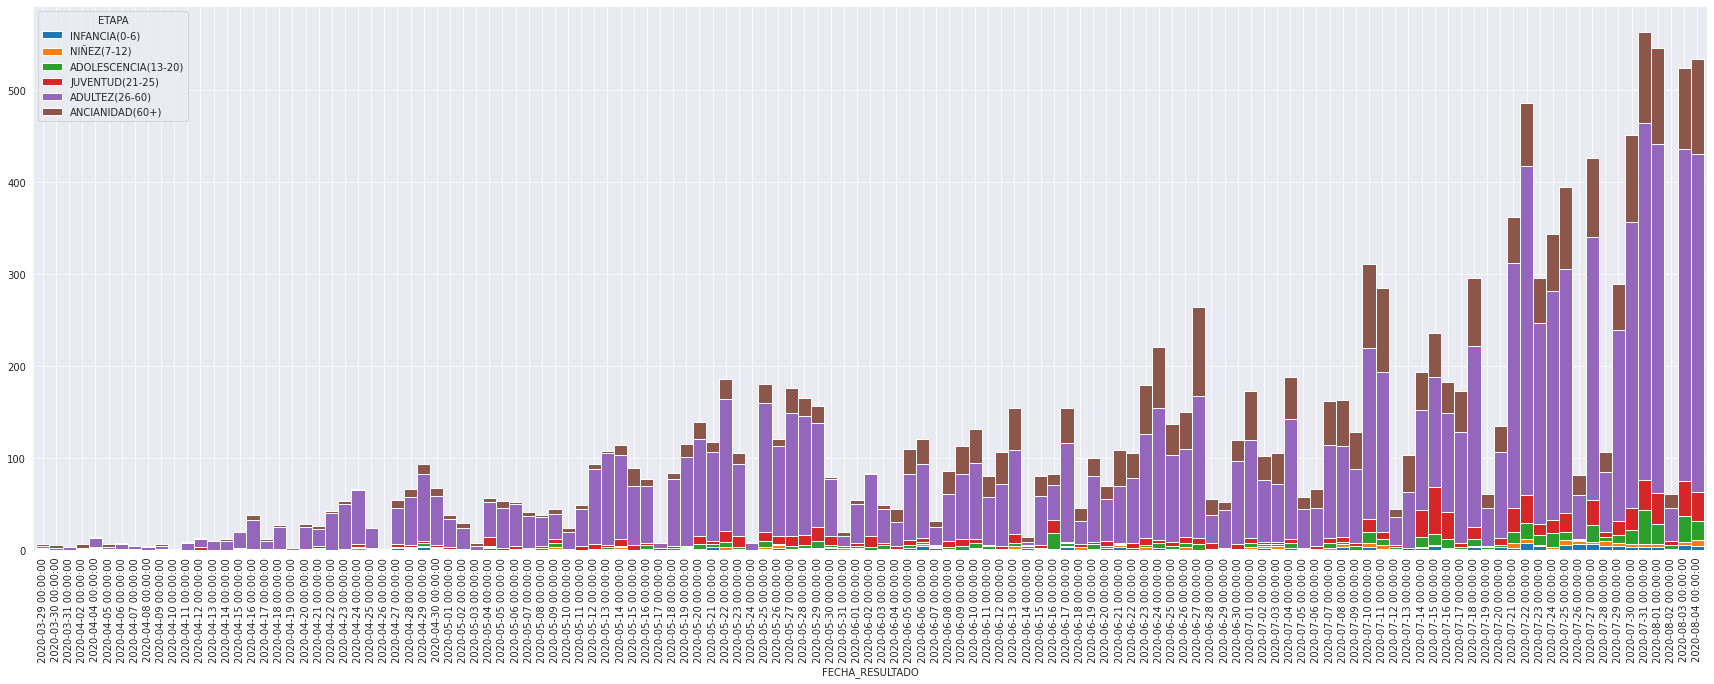

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

df_etapas.plot(kind='bar', stacked=True, width=1, ax=ax1)

plt.savefig('image_18.png')
plt.show()

In [ ]:
df_plot = df_etapas.copy()
df_plot['SUM'] = df_plot.sum(axis=1)

df_plot['INFANCIA(0-6)'] = df_plot['INFANCIA(0-6)'] / df_plot['SUM']
df_plot['NIÑEZ(7-12)'] = df_plot['NIÑEZ(7-12)'] / df_plot['SUM']
df_plot['ADOLESCENCIA(13-20)'] = df_plot['ADOLESCENCIA(13-20)'] / df_plot['SUM']
#df_plot['ADULTEZ_INTERMEDIA'] = df_plot['ADULTEZ_INTERMEDIA'] / df_plot['SUM']
#df_plot['ADULTEZ_JOVEN'] = df_plot['ADULTEZ_JOVEN'] / df_plot['SUM']
#df_plot['ADULTEZ_TARDIA'] = df_plot['ADULTEZ_TARDIA'] / df_plot['SUM']
df_plot['JUVENTUD(21-25)'] = df_plot['JUVENTUD(21-25)'] / df_plot['SUM']
df_plot['ADULTEZ(26-60)'] = df_plot['ADULTEZ(26-60)'] / df_plot['SUM']
df_plot['ANCIANIDAD(60+)'] = df_plot['ANCIANIDAD(60+)'] / df_plot['SUM']
del df_plot['SUM']
df_plot

ETAPA,INFANCIA(0-6),NIÑEZ(7-12),ADOLESCENCIA(13-20),JUVENTUD(21-25),ADULTEZ(26-60),ANCIANIDAD(60+)
FECHA_RESULTADO,,,,,,
2020-03-29,0.000000,0.166667,0.000000,0.166667,0.333333,0.333333
2020-03-30,0.000000,0.000000,0.000000,0.000000,0.400000,0.600000
2020-03-31,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2020-04-02,0.000000,0.000000,0.000000,0.166667,0.166667,0.666667
2020-04-04,0.000000,0.071429,0.071429,0.071429,0.714286,0.071429
...,...,...,...,...,...,...
2020-07-31,0.005329,0.005329,0.065719,0.058615,0.689165,0.175844
2020-08-01,0.005495,0.005495,0.040293,0.062271,0.694139,0.192308
2020-08-02,0.000000,0.016393,0.065574,0.081967,0.590164,0.245902


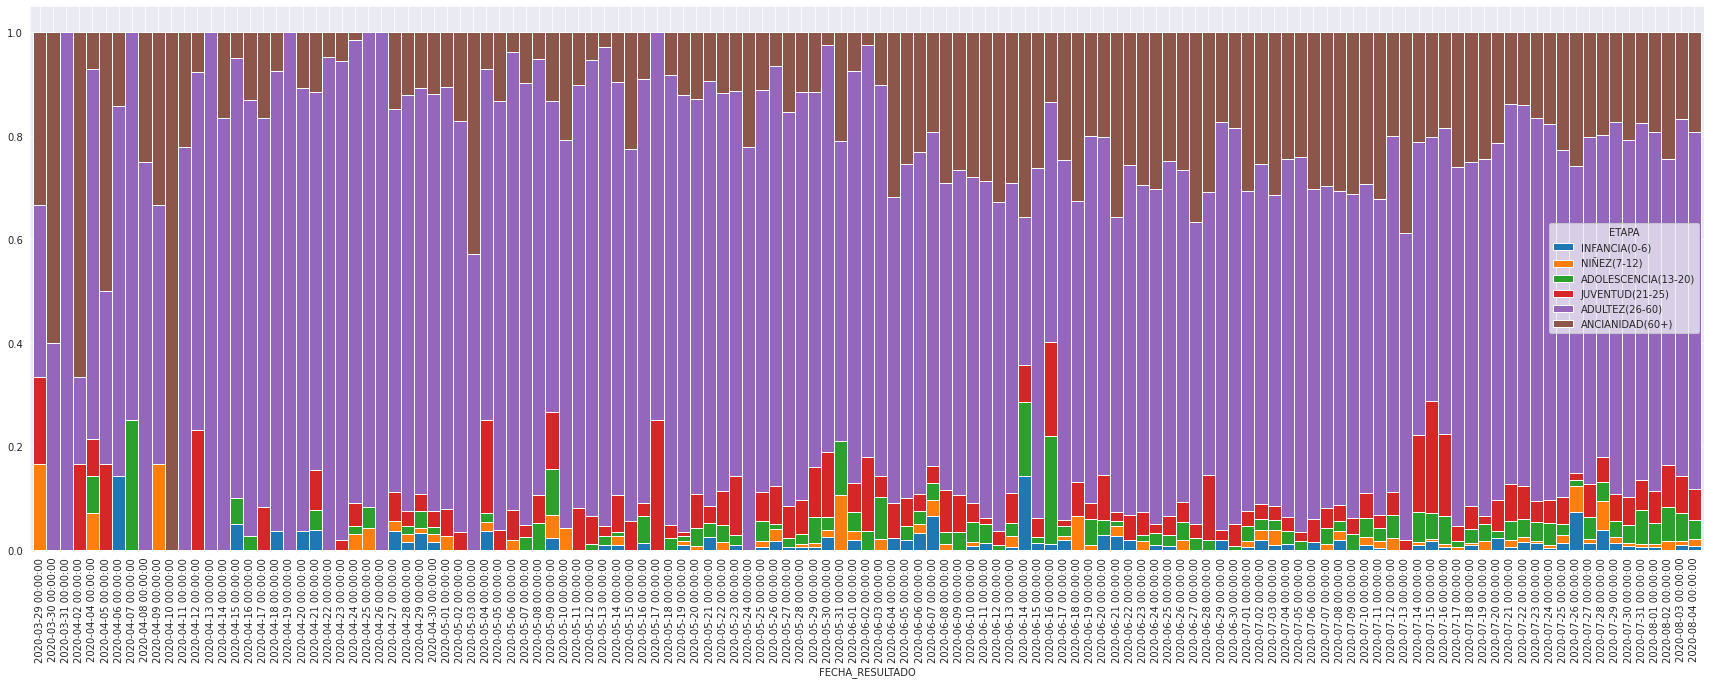

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

df_plot.plot(kind='bar', stacked=True, width=1, ax=ax1)

plt.savefig('image_19.png')
plt.show()

In [ ]:
df_edad = df_arequipa_pro.EDAD
#df_edad.replace([0], np.nan, inplace=True)
display(df_edad.value_counts().sort_index().shape)
df_edad.describe()

(101,)

count    15027.000000
mean        45.961270
std         17.234042
min          0.000000
25%         33.000000
50%         45.000000
75%         57.000000
max        106.000000
Name: EDAD, dtype: float64

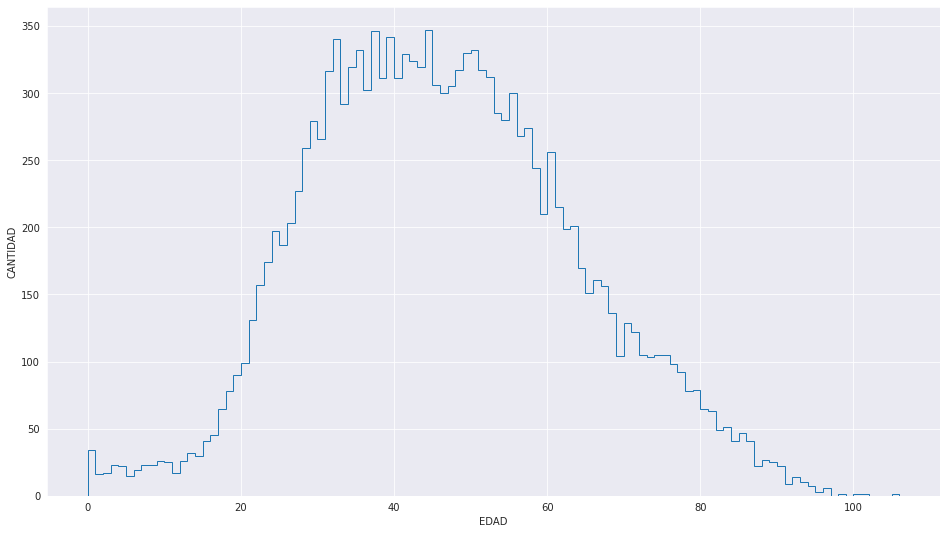

In [ ]:
plt.figure(figsize=(16,9))
plt.hist(df_edad.dropna(), bins=106, histtype='step')
plt.xlabel('EDAD')
plt.ylabel('CANTIDAD')
plt.show()

In [ ]:
is_masculine = df_arequipa_pro.SEXO == 'MASCULINO'
is_PCR = df_arequipa_pro.METODODX == 'PCR'
edad_sex_masculine = df_edad[is_masculine]
edad_sex_femenine = df_edad[~is_masculine]
print('Promedio de Edad Hombres: ', edad_sex_masculine.mean())
print('Promedio de Edad Mujeres: ',edad_sex_femenine.mean())

edad_sex_masculine_pcr = df_edad[is_masculine & is_PCR]
edad_sex_femenine_pcr = df_edad[~is_masculine & is_PCR]
print('Promedio de Edad Hombres - PCR: ',edad_sex_masculine_pcr.mean())
print('Promedio de Edad Mujeres - PCR: ',edad_sex_femenine_pcr.mean())

Promedio de Edad Hombres:  46.30344009489917
Promedio de Edad Mujeres:  45.524026072457175
Promedio de Edad Hombres - PCR:  52.51807825656265
Promedio de Edad Mujeres - PCR:  51.12703101920236


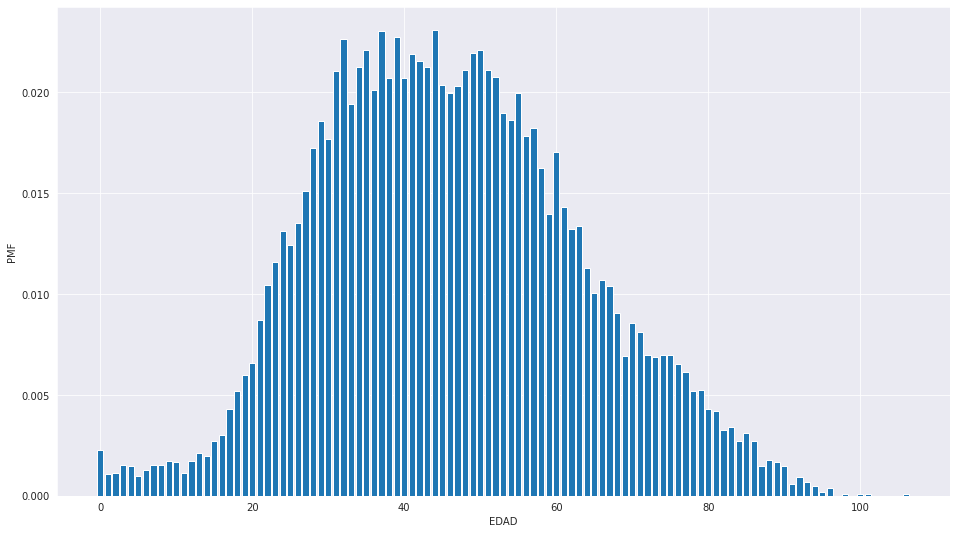

In [ ]:
pmf_age_result = Pmf.from_seq(df_edad)
# Plot the PMF
plt.figure(figsize=(16,9))
pmf_age_result.bar()

# Label the axes
plt.xlabel('EDAD')
plt.ylabel('PMF')
plt.show()

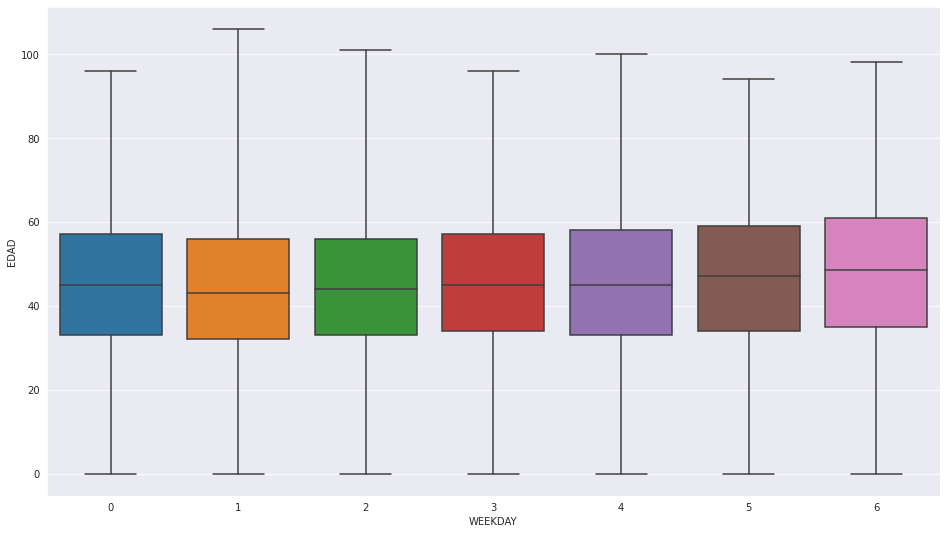

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(data = df_arequipa_pro, x='WEEKDAY', y='EDAD', whis=10)
#plt.yscale('log')
plt.show()

# SINADEF

In [118]:
MY_EXCEL_URL="https://cloud.minsa.gob.pe/s/NctBnHXDnocgWAg/download?path=%2F&files=SINADEF_DATOS_ABIERTOS_08082020.xlsx&downloadStartSecret=b9n0l9odbvq"
datos_sinadef_raw = pd.read_excel(MY_EXCEL_URL,
                       sheet_name='Tabla_SINADEF',
                       skiprows=range(3),
                       skipfooter=0)

,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X)
0,1,SIS,MASCULINO,40,AÑOS,SOLTERO,SECUNDARIA INCOMPLETA,92-33-07-01-01-000,PERU,CUSCO,CUSCO,CUSCO,2020-01-24,2020,1,EESS,GOBIERNO REGIONAL,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SHOCK NEUROGENICO,SIN REGISTRO,EPILEPSIA,G409,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
1,2,SIS,MASCULINO,43,AÑOS,SOLTERO,SUPERIOR NO UNIV. COMP.,92-33-24-01-01-000,PERU,CALLAO,CALLAO,CALLAO,2020-01-30,2020,1,EESS,MINSA,SIN REGISTRO,SI SE REALIZÓ NECROPSIA,EDEMA CEREBRAL Y PULMONAR,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
2,3,IGNORADO,MASCULINO,91,AÑOS,CASADO,IGNORADO,92-33-06-01-06-000,PERU,CAJAMARCA,CAJAMARCA,JESUS,2020-01-19,2020,1,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA MULTIORGANICA,SIN REGISTRO,SEPSIS SISTÉMICA,SIN REGISTRO,ADULTO MAYOR FRÁGIL,SIN REGISTRO,INFECCIÓN URINARIA COMPLICADA,SIN REGISTRO,HIPERTROFIA PROSTÁTICA,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
3,4,ESSALUD,MASCULINO,80,AÑOS,CASADO,IGNORADO,92-33-12-01-01-000,PERU,LA LIBERTAD,TRUJILLO,TRUJILLO,2020-01-13,2020,1,EESS,ESSALUD,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA NO ESPECIFICADA,J189,INFECCIÓN POR CORONAVIRUS,B342,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
4,5,IGNORADO,MASCULINO,24,AÑOS,SOLTERO,IGNORADO,92-33-06-02-01-000,PERU,CAJAMARCA,CAJABAMBA,CAJABAMBA,2020-01-17,2020,1,IGNORADO,SIN REGISTRO,HOMICIDIO,SI SE REALIZÓ NECROPSIA,A DETERMINAR LUEGO DE ESTUDIOS COMPLEMENTARIOS,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454146,454147,SIS,FEMENINO,85,AÑOS,CASADO,PRIMARIA INCOMPLETA,92-33-02-07-04-000,PERU,ANCASH,HUAYLAS,HUAYLAS,2019-12-05,2019,12,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,SINDROME DE DIFICULTAD RESPIRATORIA,J80X,NEUMONIA,J189,FIBROSIS PULMONAR,J849,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
454147,454148,SIS,FEMENINO,83,AÑOS,VIUDO,PRIMARIA INCOMPLETA,92-33-01-05-04-000,PERU,AMAZONAS,RODRIGUEZ DE MENDOZA,HUAMBO,2019-12-13,2019,12,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA,J969,INFARTO AGUDO DE MIOCARDIO,I219,HIPERTENSION ARTERIAL,I10X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
454148,454149,SIS,FEMENINO,94,AÑOS,VIUDO,NINGUN NIVEL / ILETRADO,92-33-01-05-04-000,PERU,AMAZONAS,RODRIGUEZ DE MENDOZA,HUAMBO,2019-12-24,2019,12,OTRO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,INFART AGUDO DE MIOCARDIO,I252,HIPERTENSION ARTERIAL,I10X,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO
454149,454150,SIS,FEMENINO,85,AÑOS,CASADO,NINGUN NIVEL / ILETRADO,92-33-01-04-22-000,PERU,AMAZONAS,LUYA,TRITA,2019-12-02,2019,12,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA CARDIACA ESPICIFICADAD,I509,INFARTO AGUDO DEL MIOCARDIO OTRA ESPECIFICADA,I219,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO


In [120]:
datos_sinadef_raw['SEMANA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.week

In [121]:
datos_sinadef_semana = datos_sinadef_raw.groupby(['SEMANA', 'AÑO'])['Nº'].count()
datos_sinadef_semana = datos_sinadef_semana.to_frame().reset_index()
datos_sinadef_semana = datos_sinadef_semana[datos_sinadef_semana['SEMANA'] <= 31 ]
datos_sinadef_semana

,SEMANA,AÑO,Nº
0,1,2017,1585
1,1,2018,2284
2,1,2019,2621
3,1,2020,1614
4,2,2017,1671
...,...,...,...
119,30,2020,6395
120,31,2017,1929
121,31,2018,2388
122,31,2019,2231


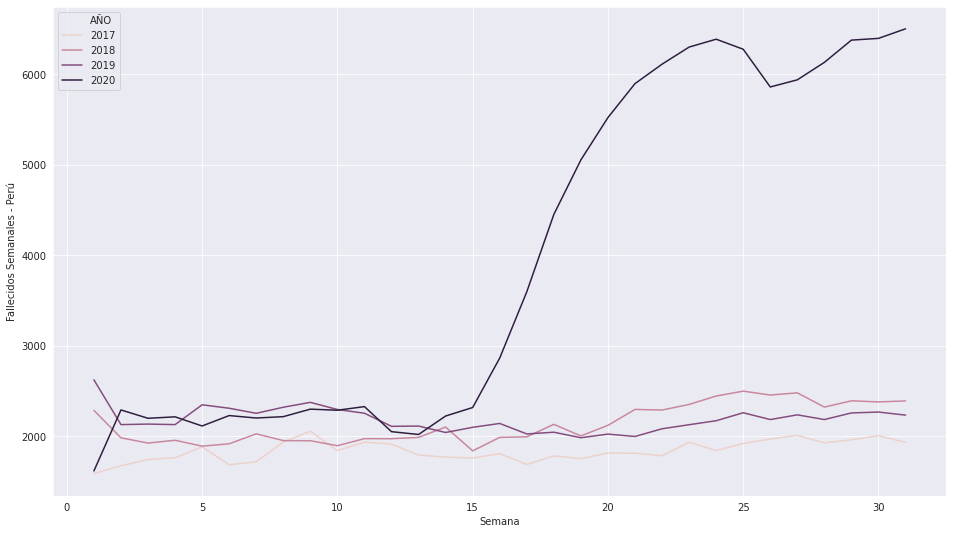

In [122]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_semana, x = 'SEMANA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Perú')

plt.savefig('image_20.png')
plt.show()

In [123]:
datos_sinadef_no_violenta = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]
datos_sinadef_arequipa = datos_sinadef_no_violenta[datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA']
datos_sinadef_arequipa['SEMANA'] = pd.to_datetime(datos_sinadef_arequipa['FECHA']).dt.week
datos_sinadef_arequipa = datos_sinadef_arequipa.reset_index(drop=True)
datos_sinadef_arequipa.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Nº,TIPO SEGURO,SEXO,EDAD,TIEMPO EDAD,ESTADO CIVIL,NIVEL DE INSTRUCCIÓN,COD# UBIGEO DOMICILIO,PAIS DOMICILIO,DEPARTAMENTO DOMICILIO,PROVINCIA DOMICILIO,DISTRITO DOMICILIO,FECHA,AÑO,MES,TIPO LUGAR,INSTITUCION,MUERTE VIOLENTA,NECROPSIA,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),SEMANA
22815,453034,PRIVADOS,FEMENINO,86,AÑOS,CASADO,SUPERIOR UNIV. INC.,92-33-04-01-02-000,PERU,AREQUIPA,AREQUIPA,CAYMA,2019-11-19,2019,11,EESS,PRIVADO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,CHOQUE CARDIOGÉNICO,R570,"SEPSIS, NO ESPECIFICADA",A419,INSUFICIENCIA RESPIRATORIA AGUDA,J960,"NEUMONÍA, NO ESPECIFICADA",J189,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,47
22816,453035,PRIVADOS,FEMENINO,97,AÑOS,VIUDO,PRIMARIA INCOMPLETA,92-33-04-01-23-000,PERU,AREQUIPA,AREQUIPA,YANAHUARA,2019-11-06,2019,11,EESS,PRIVADO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,CHOQUE CARDIOGÉNICO,R570,"SEPSIS, NO ESPECIFICADA",A419,INSUFICIENCIA RESPIRATORIA AGUDA,J960,"NEUMONÍA, NO ESPECIFICADA",J189,"INSUFICIENCIA CARDÍACA, NO ESPECIFICADA",I509,SIN REGISTRO,SIN REGISTRO,45
22817,453037,SIS,FEMENINO,88,AÑOS,CASADO,NINGUN NIVEL / ILETRADO,92-33-04-06-06-000,PERU,AREQUIPA,CONDESUYOS,SALAMANCA,2019-11-12,2019,11,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,FALLA ORGANICA MULTIPLE,R99X,SIN REGISTRO,SIN REGISTRO,INSUFICIENCIA RENAL CRONICA,N189,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,46
22818,454077,SIS,MASCULINO,86,AÑOS,VIUDO,PRIMARIA INCOMPLETA,92-33-04-08-02-000,PERU,AREQUIPA,LA UNION,ALCA,2019-12-23,2019,12,OTRO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA CARDIACA,R092,HIPOVOLEMIA,E86X,VASO DILATACIÓN,I739,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,SIN REGISTRO,52
22819,454081,SIS,MASCULINO,76,AÑOS,SOLTERO,PRIMARIA INCOMPLETA,92-33-04-08-03-000,PERU,AREQUIPA,LA UNION,CHARCANA,2019-12-08,2019,12,DOMICILIO,SIN REGISTRO,SIN REGISTRO,NO SE REALIZÓ NECROPSIA,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONITIS POR ASPIRACIÓN,J698,INTOXICACIÓN ALCOHOLICA AGUDA,Y919,SIN REGISTRO,SIN REGISTRO,ALCOHOLISMO,SIN REGISTRO,DESNUTRICIÓN,SIN REGISTRO,49


In [124]:
datos_sinadef_arequipa_semana = datos_sinadef_arequipa.groupby(['SEMANA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana.to_frame().reset_index()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana[datos_sinadef_arequipa_semana['SEMANA'] <= 31 ]
datos_sinadef_arequipa_semana

,SEMANA,AÑO,Nº
0,1,2017,84
1,1,2018,105
2,1,2019,143
3,1,2020,80
4,2,2017,78
...,...,...,...
119,30,2020,637
120,31,2017,86
121,31,2018,125
122,31,2019,139


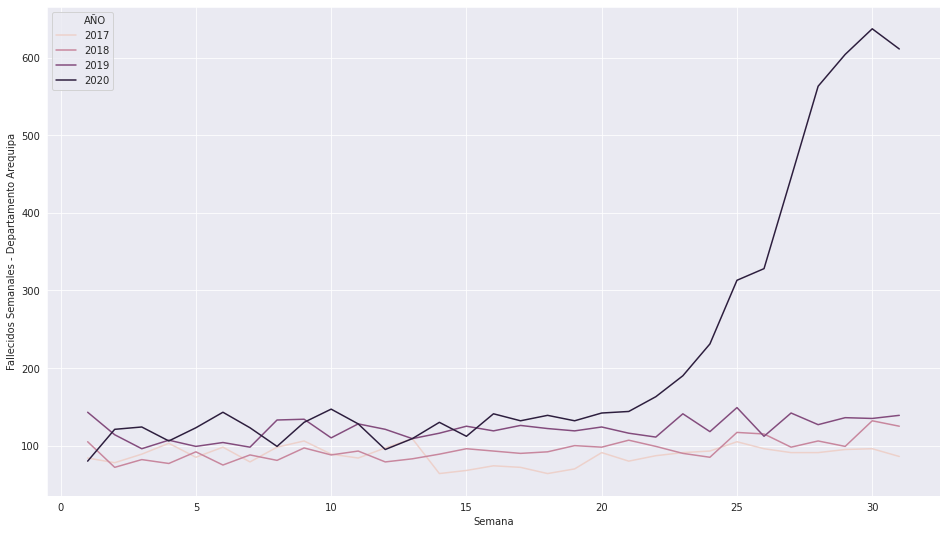

In [125]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana, x = 'SEMANA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')

plt.savefig('image_21.png')
plt.show()

In [126]:
datos_arequipa_semana = datos_arequipa.groupby(['week', 'year'])['fallecidos_diarios'].sum()
datos_arequipa_semana = datos_arequipa_semana.to_frame().reset_index()
datos_arequipa_semana = datos_arequipa_semana[datos_arequipa_semana['week'] <= 31 ]

datos_arequipa_semana

,week,year,fallecidos_diarios
0,18,2020,4
1,19,2020,10
2,20,2020,7
3,21,2020,10
4,22,2020,20
5,23,2020,18
6,24,2020,48
7,25,2020,83
8,26,2020,79
9,27,2020,113


In [127]:
datos_sinadef_arequipa_covid = datos_sinadef_arequipa[datos_sinadef_arequipa['CAUSA A (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA B (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA C (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA D (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA E (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA F (CIE-X)'].str.contains("U07") |
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("CORONAVIRUS")
                                                       ]

#display(df_sinadef_raw_arequipa_covid)

datos_sinadef_arequipa_covid['week'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.week
datos_sinadef_arequipa_covid['year'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.year
datos_sinadef_arequipa_covid = datos_sinadef_arequipa_covid.reset_index(drop=True)

datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_covid.groupby(['week', 'year'])['Nº'].count()
datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid.to_frame().reset_index()
datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid[(datos_sinadef_arequipa_semana_covid['week'] >= 18) & (datos_sinadef_arequipa_semana_covid['week'] <= 31)]

datos_sinadef_arequipa_semana_covid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,week,year,Nº
4,18,2020,10
5,19,2020,18
6,20,2020,14
7,21,2020,26
8,22,2020,54
9,23,2020,56
10,24,2020,89
11,25,2020,144
12,26,2020,166
13,27,2020,226


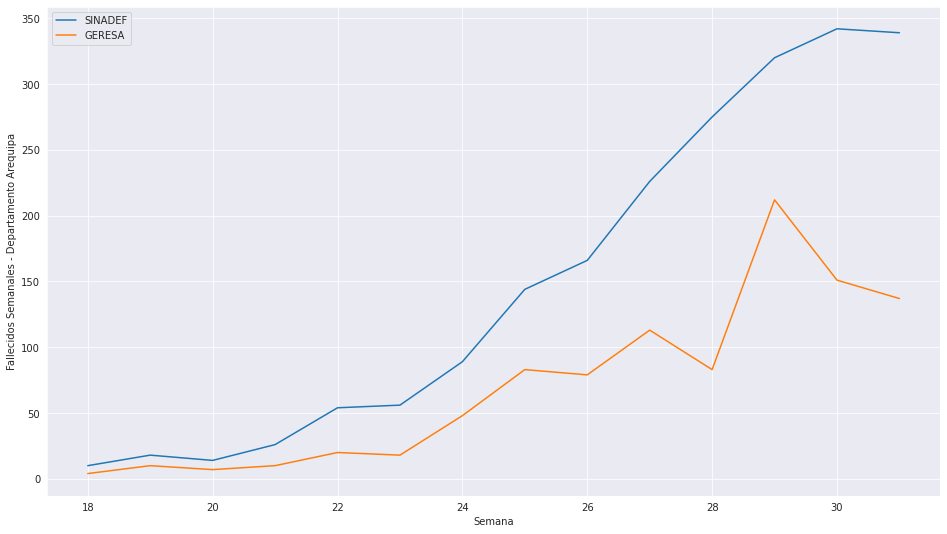

In [128]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana_covid, x = 'week', y = 'Nº', label='SINADEF', ax=ax1)
sns.lineplot(data=datos_arequipa_semana, x = 'week', y = 'fallecidos_diarios', label='GERESA', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')

plt.savefig('image_22.png')
plt.show()

## Clustering

In [148]:
datos_sinadef_no_violenta = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]

In [149]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]

datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample.replace('SIN REGISTRO', ' ')

datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample[['DEBIDO A (CAUSA A)',
                                                                                     'CAUSA A (CIE-X)',
                                                                                     'DEBIDO A (CAUSA B)',
                                                                                     'CAUSA B (CIE-X)',
                                                                                     'DEBIDO A (CAUSA C)',
                                                                                     'CAUSA C (CIE-X)',
                                                                                     'DEBIDO A (CAUSA D)',
                                                                                     'CAUSA D (CIE-X)',
                                                                                     'DEBIDO A (CAUSA E)',
                                                                                     'CAUSA E (CIE-X)',
                                                                                     'DEBIDO A (CAUSA F)',
                                                                                     'CAUSA F (CIE-X)']]

datos_sinadef_arequipa_clustering_sample['all_features'] =  datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA A)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA A (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA B)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA B (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA C)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA C (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA D)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA D (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA E)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA E (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA F)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA F (CIE-X)']

datos_sinadef_arequipa_clustering_sample

,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),all_features
40,TRAUMATISMO ENCEFALO CRANEANO,S069,AHOGAMIENTO Y SUMERSIÓN EN RÍO,W698,,,,,,,,,TRAUMATISMO ENCEFALO CRANEANO S069 AHOGAMIENTO...
49,NEOPLASIA DE PANCREAS,,,,,,,,,,,,NEOPLASIA DE PANCREAS
161,IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...,,,,,,,,,,,,IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...
215,CHOQUE SEPTICO,R572,BRONCONEUMONIA,J180,ENFERMEDAD POR VIH,B207,,,,,,,CHOQUE SEPTICO R572 BRONCONEUMONIA J180 ENFERM...
222,INSUFICIENCIA RESPIRATORIA,,ENFERMEDAD DE MEMBRANA HIALINA,,RECIÉN NACIDO DE PARTO PRETÉRMINO,,,,,,,,INSUFICIENCIA RESPIRATORIA ENFERMEDAD DE MEM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127187,SINDROME INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA VIRAL,J129,COVID 19 CASO SOSPECHOSO,U072,,,,,,,SINDROME INSUFICIENCIA RESPIRATORIA J960 NEUMO...
127188,SINDROME DE INSUFICIENCIA RESPIRATORIA,J960,NEMONIA VIRAL,J129,COVID 19 CASO SOSPECHOSO,U072,,,,,,,SINDROME DE INSUFICIENCIA RESPIRATORIA J960 NE...
127189,SINDROME INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA VIRAL,J129,COVID CASO CONFIRMADO,U071,,,,,,,SINDROME INSUFICIENCIA RESPIRATORIA J960 NEUMO...
127190,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,COVID NO IDENTIFICADO,U072,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...


In [150]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for column in datos_sinadef_arequipa_clustering_sample.columns:
    for char in spec_chars:
        datos_sinadef_arequipa_clustering_sample[column] = datos_sinadef_arequipa_clustering_sample[column].str.replace(char, ' ')

In [152]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [153]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['mostly',
 'for',
 'themselves',
 'n‘t',
 'how',
 'about',
 'really',
 'six',
 'say',
 'together']

In [154]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [155]:
from tqdm import tqdm
tqdm.pandas()
datos_sinadef_arequipa_clustering_sample["processed_text"] = datos_sinadef_arequipa_clustering_sample['all_features'].progress_apply(spacy_tokenizer)

100%|██████████| 7101/7101 [00:32<00:00, 219.01it/s]


In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [157]:
text = datos_sinadef_arequipa_clustering_sample['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(7101, 3289)

In [158]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(7101, 1154)

In [159]:
from sklearn.cluster import KMeans

In [160]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

Found distortion for 2 clusters
Found distortion for 3 clusters
Found distortion for 4 clusters
Found distortion for 5 clusters
Found distortion for 6 clusters
Found distortion for 7 clusters
Found distortion for 8 clusters
Found distortion for 9 clusters
Found distortion for 10 clusters
Found distortion for 11 clusters
Found distortion for 12 clusters
Found distortion for 13 clusters
Found distortion for 14 clusters
Found distortion for 15 clusters
Found distortion for 16 clusters
Found distortion for 17 clusters
Found distortion for 18 clusters
Found distortion for 19 clusters
Found distortion for 20 clusters
Found distortion for 21 clusters
Found distortion for 22 clusters
Found distortion for 23 clusters
Found distortion for 24 clusters
Found distortion for 25 clusters
Found distortion for 26 clusters
Found distortion for 27 clusters
Found distortion for 28 clusters
Found distortion for 29 clusters
Found distortion for 30 clusters
Found distortion for 31 clusters
Found distortion f

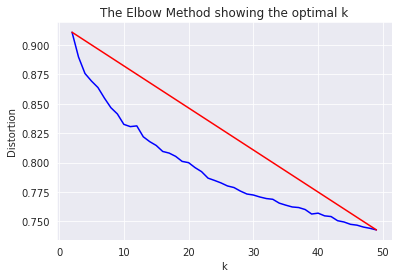

In [161]:
import matplotlib.pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow_departamento_arequipa_covid.png')
plt.show()

In [227]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
datos_sinadef_arequipa_clustering_sample['y'] = y_pred

In [228]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7101 samples in 3.953s...
[t-SNE] Computed neighbors for 7101 samples in 345.855s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7101
[t-SNE] Computed conditional probabilities for sample 2000 / 7101
[t-SNE] Computed conditional probabilities for sample 3000 / 7101
[t-SNE] Computed conditional probabilities for sample 4000 / 7101
[t-SNE] Computed conditional probabilities for sample 5000 / 7101
[t-SNE] Computed conditional probabilities for sample 6000 / 7101
[t-SNE] Computed conditional probabilities for sample 7000 / 7101
[t-SNE] Computed conditional probabilities for sample 7101 / 7101
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.114456
[t-SNE] KL divergence after 1000 iterations: 1.553082


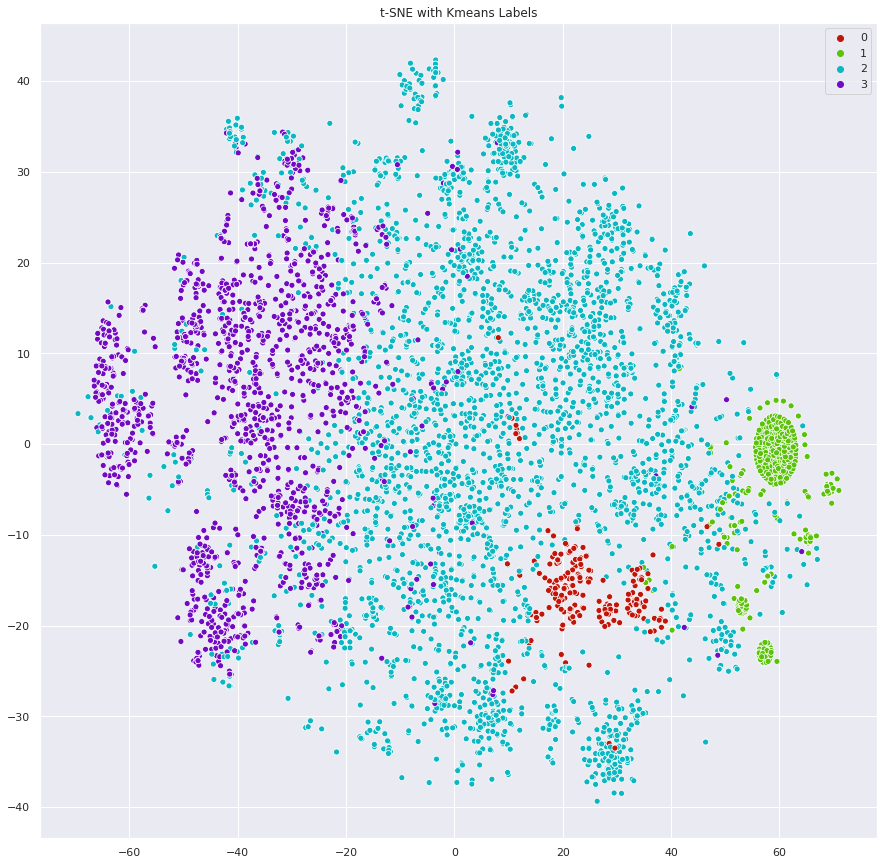

In [229]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(4, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("departamento_arequipa_2020.png")
plt.show()

In [230]:
X_embedded.shape

(7101, 2)

In [231]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [232]:
vectorizers = []
    
for ii in range(0, 4):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [233]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(datos_sinadef_arequipa_clustering_sample.loc[datos_sinadef_arequipa_clustering_sample['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
        
len(vectorized_data)

4

In [234]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 5

lda_models = []
for ii in range(0, 4):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [235]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3


In [236]:
len(clusters_lda_data[0])

432

In [237]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [238]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [239]:
display(all_keywords[0][:10])
len(all_keywords)

['agudo',
 'infarto',
 'miocardio',
 'renal',
 'deficiencia',
 'hepato',
 'accidente',
 'vascular',
 'pulmonar']

4

In [240]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [244]:
df = datos_sinadef_arequipa_clustering_sample[datos_sinadef_arequipa_clustering_sample['y'] == 3]
display(df)

df.to_csv('df.csv')

df['processed_text'].to_csv('nube_palabras.csv')

from collections import Counter
results = Counter()
df['processed_text'].str.lower().str.split().apply(results.update)
print(results)

,DEBIDO A (CAUSA A),CAUSA A (CIE-X),DEBIDO A (CAUSA B),CAUSA B (CIE-X),DEBIDO A (CAUSA C),CAUSA C (CIE-X),DEBIDO A (CAUSA D),CAUSA D (CIE-X),DEBIDO A (CAUSA E),CAUSA E (CIE-X),DEBIDO A (CAUSA F),CAUSA F (CIE-X),all_features,processed_text,y
432,INSUFICIENCIA RESPIRATORIA,J80X,,,,,,,,,,,INSUFICIENCIA RESPIRATORIA J80X ...,insuficiencia respiratoria j80x,3
3222,INSUFICIENCIA RESPIRATORIA AGUDA,,NEUMONIA,,,,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA NEUMONIA ...,insuficiencia respiratoria aguda neumonia,3
6308,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA,J189,,,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3
7837,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA,J189,,,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3
8347,INSUFICIENCIA RESPIRATORIA,J80X,,,,,,,,,,,INSUFICIENCIA RESPIRATORIA J80X ...,insuficiencia respiratoria j80x,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127187,SINDROME INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA VIRAL,J129,COVID 19 CASO SOSPECHOSO,U072,,,,,,,SINDROME INSUFICIENCIA RESPIRATORIA J960 NEUMO...,sindrome insuficiencia respiratoria j960 neumo...,3
127188,SINDROME DE INSUFICIENCIA RESPIRATORIA,J960,NEMONIA VIRAL,J129,COVID 19 CASO SOSPECHOSO,U072,,,,,,,SINDROME DE INSUFICIENCIA RESPIRATORIA J960 NE...,sindrome de insuficiencia respiratoria j960 ne...,3
127189,SINDROME INSUFICIENCIA RESPIRATORIA,J960,NEUMONIA VIRAL,J129,COVID CASO CONFIRMADO,U071,,,,,,,SINDROME INSUFICIENCIA RESPIRATORIA J960 NEUMO...,sindrome insuficiencia respiratoria j960 neumo...,3
127190,INSUFICIENCIA RESPIRATORIA AGUDA,J960,NEUMONIA VIRAL,J129,COVID NO IDENTIFICADO,U072,,,,,,,INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...,insuficiencia respiratoria aguda j960 neumonia...,3


Counter({'respiratoria': 2041, 'insuficiencia': 1848, 'covid': 1567, 'neumonia': 1481, '19': 1278, 'j960': 1246, 'u071': 1163, 'aguda': 1086, 'por': 864, 'u072': 712, 'j80x': 447, 'virus': 421, 'identificado': 397, 'infeccion': 343, 'severa': 332, 'viral': 316, 'de': 298, 'sars': 293, '2': 273, 'j969': 267, 'dificultad': 229, 'j129': 225, 'sindrome': 222, 'cov': 219, 'coronavirus': 209, 'arterial': 203, 'j189': 200, 'i10x': 191, 'hipertension': 184, 'diabetes': 181, 'atipica': 176, 'mellitus': 174, 'covid19': 151, 'j128': 147, 'obesidad': 132, 'falla': 132, 'adulto': 130, 'del': 126, 'j22x': 121, 'infección': 114, 'sospechoso': 107, 'e669': 96, 'shock': 94, 'renal': 94, 'caso': 93, 'neumonía': 84, 'r579': 80, 'multiorganica': 79, 'cov2': 78, 'especificada': 73, 'enfermedad': 70, 'respiratorio': 67, 'j180': 66, 'e119': 60, 'confirmado': 56, 'b972': 55, 'síndrome': 54, 'b342': 52, 'n179': 48, 'pulmonar': 46, 'j168': 44, 'sepsis': 42, 'bilateral': 40, 'cronica': 37, 'septico': 36, 'probab

# Varios

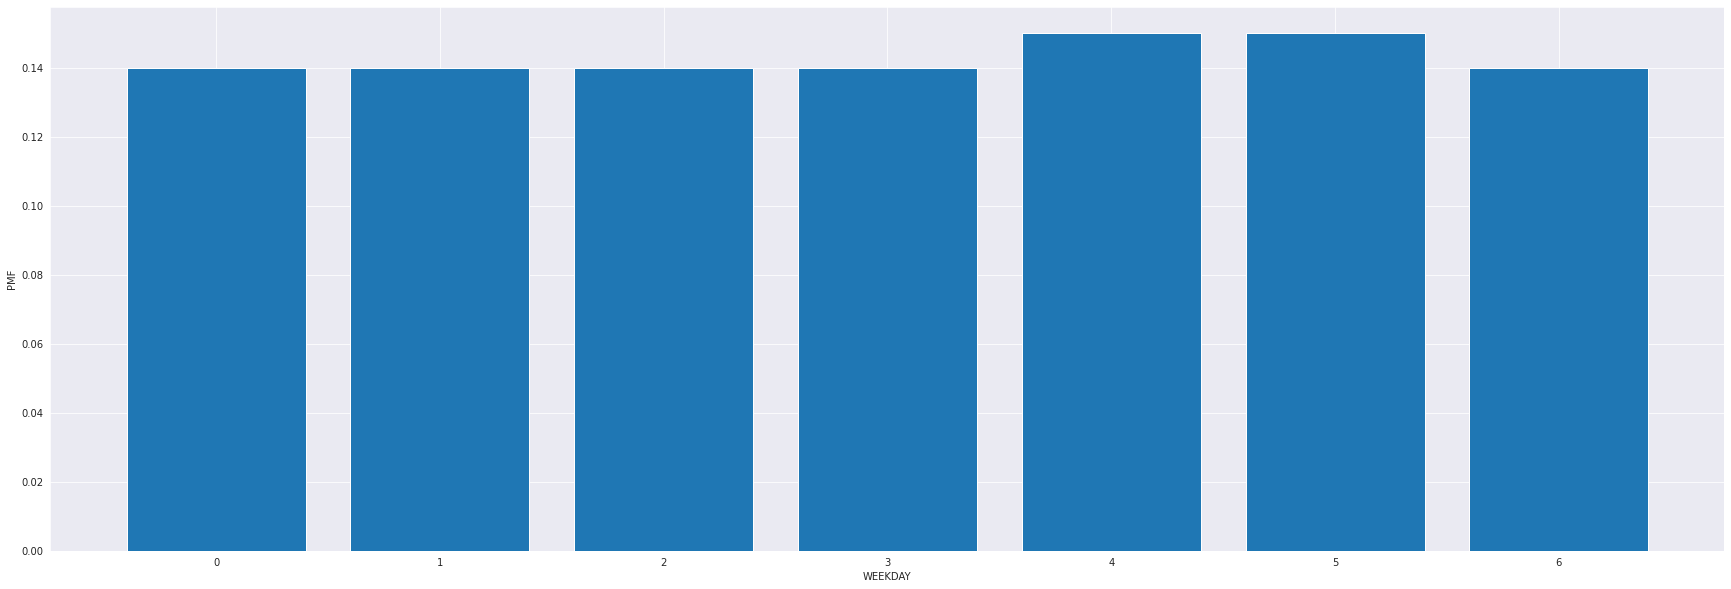

In [129]:
metododx = datos_arequipa['weekday']
plt.figure(figsize=(30,10))
Pmf.from_seq(metododx).bar()

plt.xlabel('WEEKDAY')
plt.ylabel('PMF')
plt.show()

# Estudios de correlacion y regresion

In [130]:
datos_arequipa.tail()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,activos
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-04,411395,55991,355398,6,1043,30209,430,349,42,16,358,623,12,41,9,95,1,32,2020,7232,1935,35,1412,-19,-4,26,24739
2020-08-05,419850,58056,361769,25,1074,31771,438,339,39,18,369,642,12,41,10,96,2,32,2020,8455,2065,31,1562,8,-3,24,25211
2020-08-06,428864,60430,368410,24,1113,33184,421,296,46,12,394,656,12,41,10,97,3,32,2020,9014,2374,39,1413,-17,7,26,26133
2020-08-07,439007,62931,376057,19,1142,33382,449,338,40,20,404,675,12,41,10,98,4,32,2020,10143,2501,29,198,28,-6,24,28407
2020-08-08,446570,64692,381834,44,1177,35145,474,298,40,23,415,699,12,41,10,99,5,32,2020,7563,1761,35,1763,25,0,23,28370


In [131]:
datos_arequipa.describe()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,activos
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,167463.760000,16492.910000,150927.700000,40.29000,344.490000,7744.350000,254.260000,139.050000,41.680000,10.660000,114.930000,190.830000,4.810000,11.040000,3.030000,49.500000,3.030000,25.210000,2020.0,4323.620000,640.370000,11.620000,350.620000,4.320000,0.190000,11.260000,8404.070000
std,131936.680967,17985.704541,114540.344845,51.10166,347.848292,9289.395928,167.029582,108.562636,14.274283,6.721321,119.040886,207.488301,5.104355,16.227499,3.713081,29.011492,2.002297,4.156764,0.0,2601.886537,676.662467,11.612237,443.531826,57.997367,5.609687,7.050496,8435.724152
min,14208.000000,655.000000,13552.000000,0.00000,15.000000,83.000000,40.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,2020.0,0.000000,0.000000,0.000000,0.000000,-251.000000,-20.000000,0.000000,557.000000
25%,46153.500000,2763.750000,43366.750000,8.00000,51.000000,1009.000000,84.000000,36.500000,27.000000,5.000000,12.750000,29.000000,0.000000,0.000000,0.000000,24.750000,1.000000,22.000000,2020.0,2266.750000,129.500000,2.000000,63.750000,-4.000000,-2.000000,6.000000,1727.500000
50%,134097.500000,8163.500000,125861.000000,23.00000,207.000000,3750.000000,278.500000,126.000000,46.000000,12.000000,62.500000,74.500000,3.000000,1.000000,2.000000,49.500000,3.000000,25.000000,2020.0,4009.000000,317.000000,8.000000,154.500000,1.500000,0.000000,9.000000,4206.500000
75%,269029.500000,25581.750000,243871.750000,53.25000,583.500000,11494.500000,414.000000,234.750000,53.000000,15.000000,188.000000,322.250000,11.250000,23.250000,5.750000,74.250000,5.000000,29.000000,2020.0,6482.750000,943.500000,19.000000,443.500000,11.250000,2.250000,15.000000,13503.750000
max,446570.000000,64692.000000,381834.000000,258.00000,1177.000000,35145.000000,668.000000,349.000000,74.000000,28.000000,415.000000,699.000000,12.000000,41.000000,10.000000,99.000000,6.000000,32.000000,2020.0,10143.000000,2501.000000,51.000000,1763.000000,267.000000,19.000000,31.000000,28407.000000


In [132]:
datos_arequipa.corr()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,week,year,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,hospitalizados_positivos_diarios,uci_positivos_diarios,positividad,activos
0,,,,,,,,,,,,,,,,,,,,,,,,,,,
total_muestras,1.000000,0.971250,0.999308,0.076851,0.988658,0.954427,0.894193,0.891046,0.628798,0.597186,0.938746,0.935291,0.905577,0.898274,0.928318,0.974543,0.005307,0.971302,NaN,0.837904,0.897341,0.775458,0.851994,-0.005230,-0.083922,0.884043,0.979011
casos_positivos,0.971250,1.000000,0.961728,-0.027416,0.992669,0.995503,0.790003,0.841904,0.446615,0.503769,0.946493,0.952600,0.852798,0.926890,0.921387,0.901005,0.013540,0.897414,NaN,0.761211,0.895813,0.729641,0.883306,-0.010310,-0.088709,0.892854,0.994910
casos_negativos,0.999308,0.961728,1.000000,0.092414,0.982907,0.943067,0.905795,0.894112,0.653994,0.608649,0.932675,0.927749,0.909154,0.889164,0.924625,0.980979,0.003854,0.977819,NaN,0.845523,0.892962,0.778724,0.842745,-0.004434,-0.082874,0.878132,0.971456
espera_resultado,0.076851,-0.027416,0.092414,1.000000,0.019509,-0.034595,0.214253,0.244862,0.332472,0.415128,0.093057,0.054934,0.182994,-0.067070,0.075334,0.163190,0.015709,0.161627,NaN,0.176538,0.051478,0.085690,-0.039359,-0.038101,0.036557,0.069850,-0.021162
defunciones,0.988658,0.992669,0.982907,0.019509,1.000000,0.979927,0.843207,0.863997,0.518594,0.539176,0.947993,0.953135,0.889718,0.928826,0.939642,0.932329,0.003155,0.929361,NaN,0.794306,0.905206,0.764411,0.872756,-0.008190,-0.087707,0.904202,0.996129
recuperados,0.954427,0.995503,0.943067,-0.034595,0.979927,1.000000,0.758498,0.831979,0.411487,0.495238,0.942953,0.946885,0.827407,0.909819,0.902371,0.879274,0.004423,0.876375,NaN,0.734355,0.877138,0.720027,0.887324,-0.010331,-0.086470,0.874580,0.980895
hospitalizados_positivos,0.894193,0.790003,0.905795,0.214253,0.843207,0.758498,1.000000,0.737670,0.829099,0.549703,0.724938,0.711512,0.776444,0.666252,0.742961,0.929425,-0.002138,0.926830,NaN,0.814064,0.768416,0.727542,0.691893,0.176272,0.045170,0.744496,0.814330
hospitalizados_sospechosos,0.891046,0.841904,0.894112,0.244862,0.863997,0.831979,0.737670,1.000000,0.572129,0.781778,0.943754,0.925328,0.948120,0.840979,0.914521,0.893067,-0.004979,0.890775,NaN,0.758901,0.783352,0.717567,0.731026,-0.263067,-0.274716,0.790913,0.843213
uci_positivos,0.628798,0.446615,0.653994,0.332472,0.518594,0.411487,0.829099,0.572129,1.000000,0.482943,0.440925,0.403159,0.562843,0.336311,0.442137,0.752237,-0.024753,0.751721,NaN,0.672611,0.479749,0.565869,0.386069,0.124174,0.169928,0.433116,0.477710


In [133]:
datos_arequipa['WEEKDAY'] = datos_arequipa.index.weekday

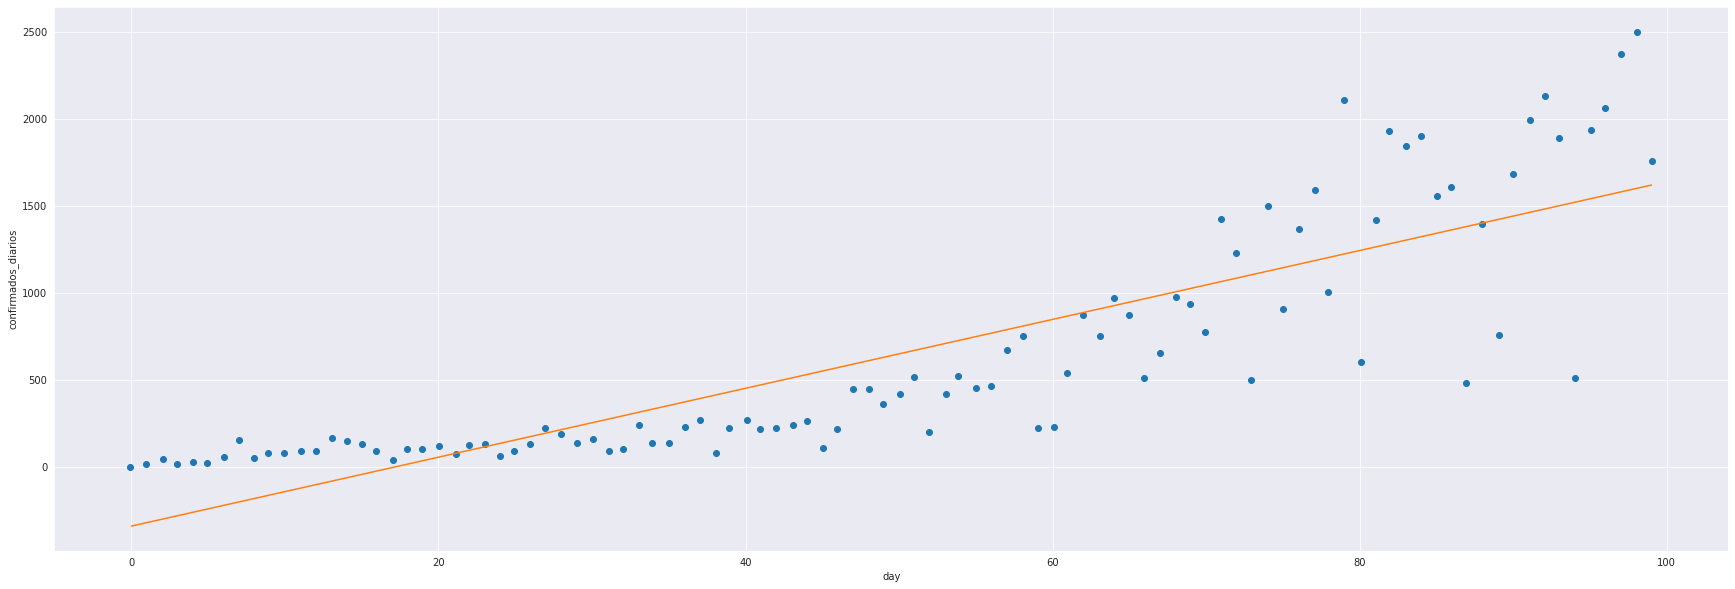

In [134]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['confirmados_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('confirmados_diarios')
plt.show()

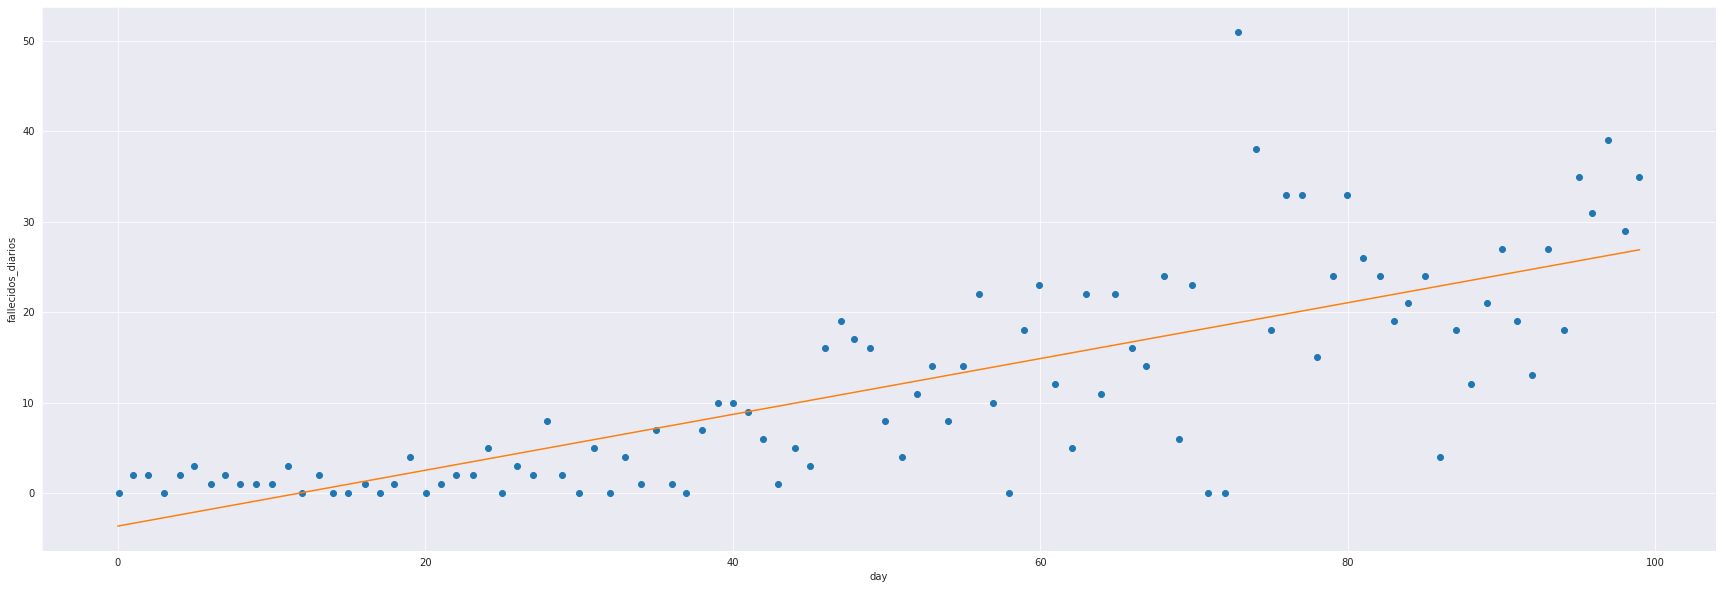

In [135]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('fallecidos_diarios')
plt.show()

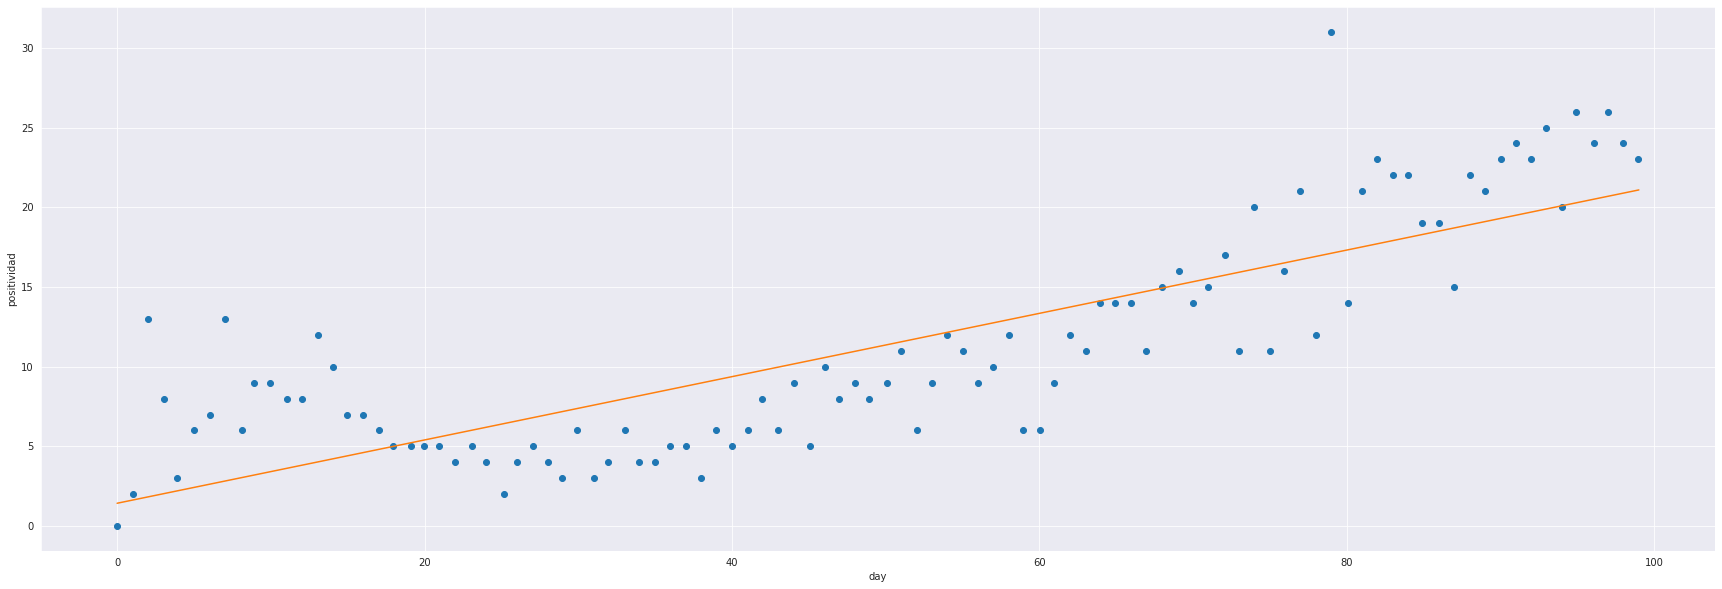

In [136]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['positividad']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('positividad')
plt.show()

In [137]:
import statsmodels.formula.api as smf

results = smf.ols('positividad ~ dia', data=datos_arequipa).fit()
results.params

Intercept    1.432475
dia          0.198536
dtype: float64

Cada dia la linea de regresion aumenta un 0.01

In [138]:
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2
datos_arequipa['dia3'] = datos_arequipa['dia'] ** 3

model = smf.ols('positividad ~ dia + dia2 + dia3', data=datos_arequipa)

results = model.fit()
results.params

Intercept    8.603353
dia         -0.318409
dia2         0.007567
dia3        -0.000026
dtype: float64

In [139]:
df = pd.DataFrame()
df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2
df['dia3'] = df['dia'] ** 3

pred12 = results.predict(df)

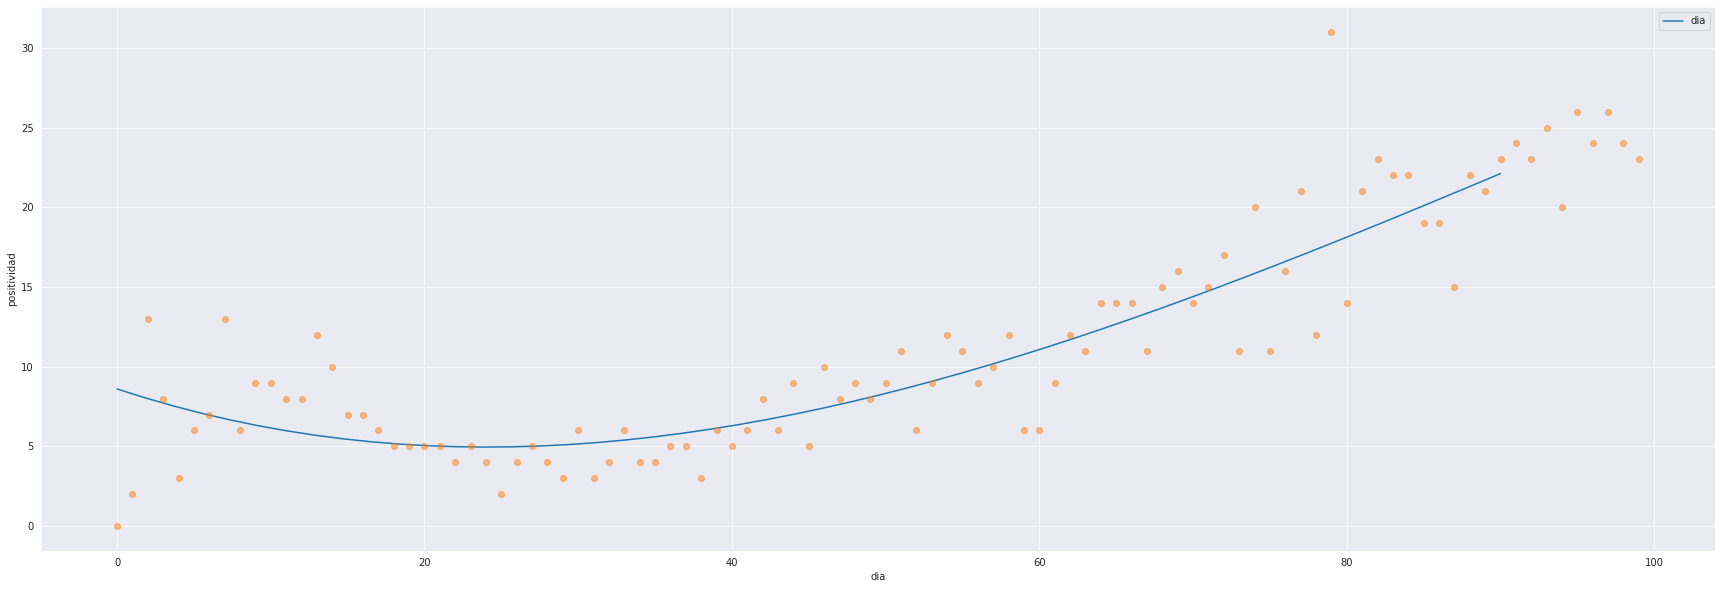

In [140]:
plt.figure(figsize=(30,10))
plt.plot(df['dia'], pred12, label='dia')
plt.plot(datos_arequipa['dia'], datos_arequipa['positividad'], 'o', alpha=0.5)

plt.xlabel('dia')
plt.ylabel('positividad')
plt.legend()
plt.show()

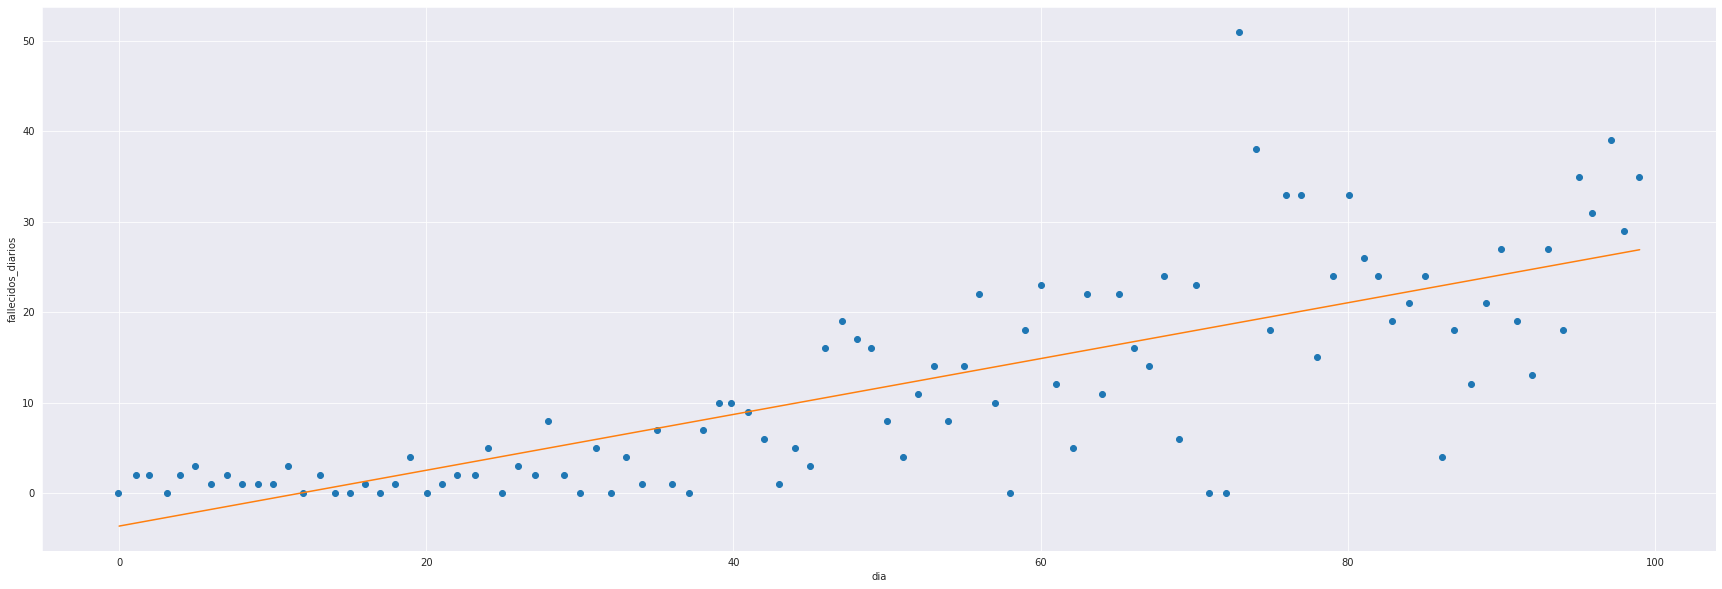

In [141]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('dia')
plt.ylabel('fallecidos_diarios')
plt.show()

In [142]:
results = smf.ols('fallecidos_diarios ~ dia + positividad', data=datos_arequipa).fit()
results.params

Intercept     -4.007775
dia            0.261493
positividad    0.238356
dtype: float64

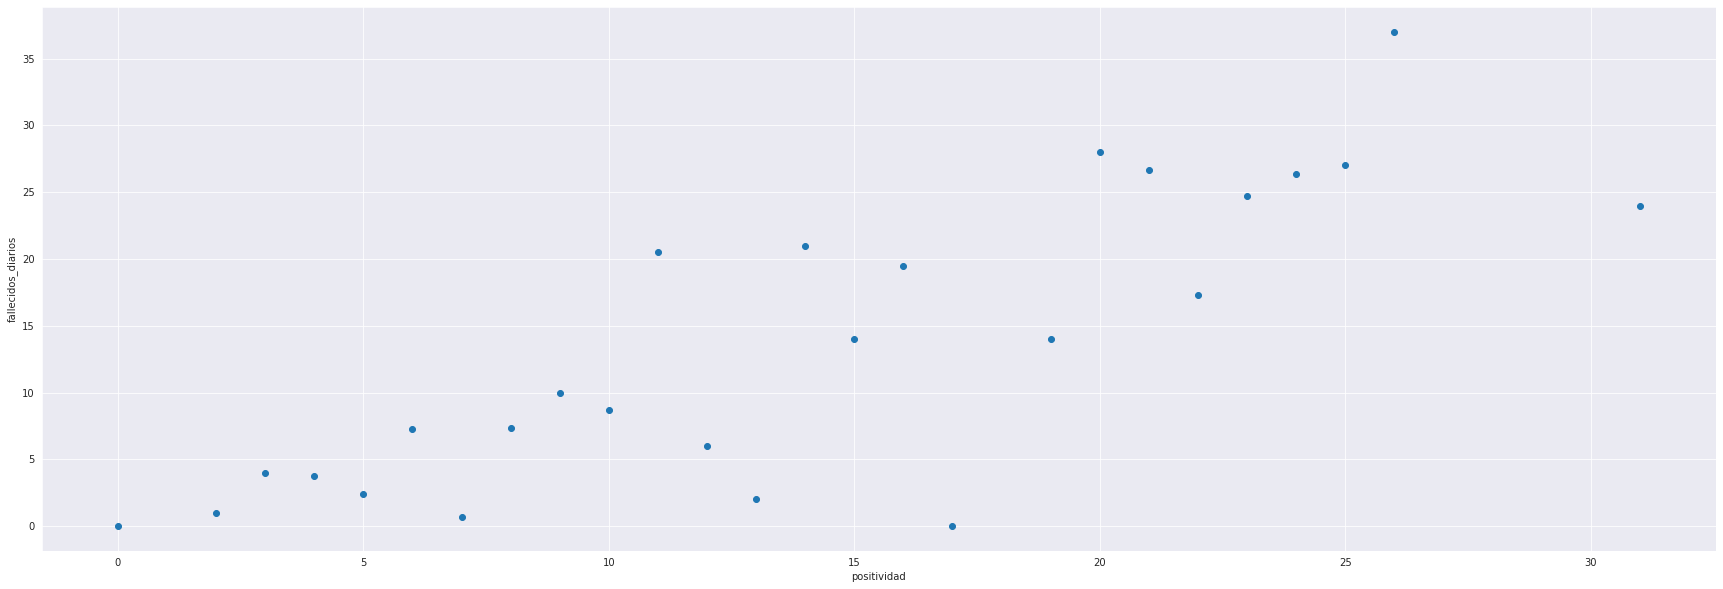

In [143]:
#grouped = datos_arequipa.groupby('dia')
grouped = datos_arequipa.groupby('positividad')
mean_positividad_by_weekday = grouped['fallecidos_diarios'].mean()
plt.figure(figsize=(30,10))
plt.plot(mean_positividad_by_weekday, 'o')

plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.show()

In [144]:
datos_arequipa['positividad2'] = datos_arequipa['positividad'] ** 2
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2

model = smf.ols('fallecidos_diarios ~ dia + dia2 + positividad + positividad2', data=datos_arequipa)
results = model.fit()
results.params

Intercept      -0.631151
dia             0.146301
dia2            0.001575
positividad    -0.079118
positividad2    0.004139
dtype: float64

In [145]:
df = pd.DataFrame()
df['positividad'] = np.linspace(0, 13)
df['positividad2'] = df['positividad'] ** 2

df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2

pred12 = results.predict(df)

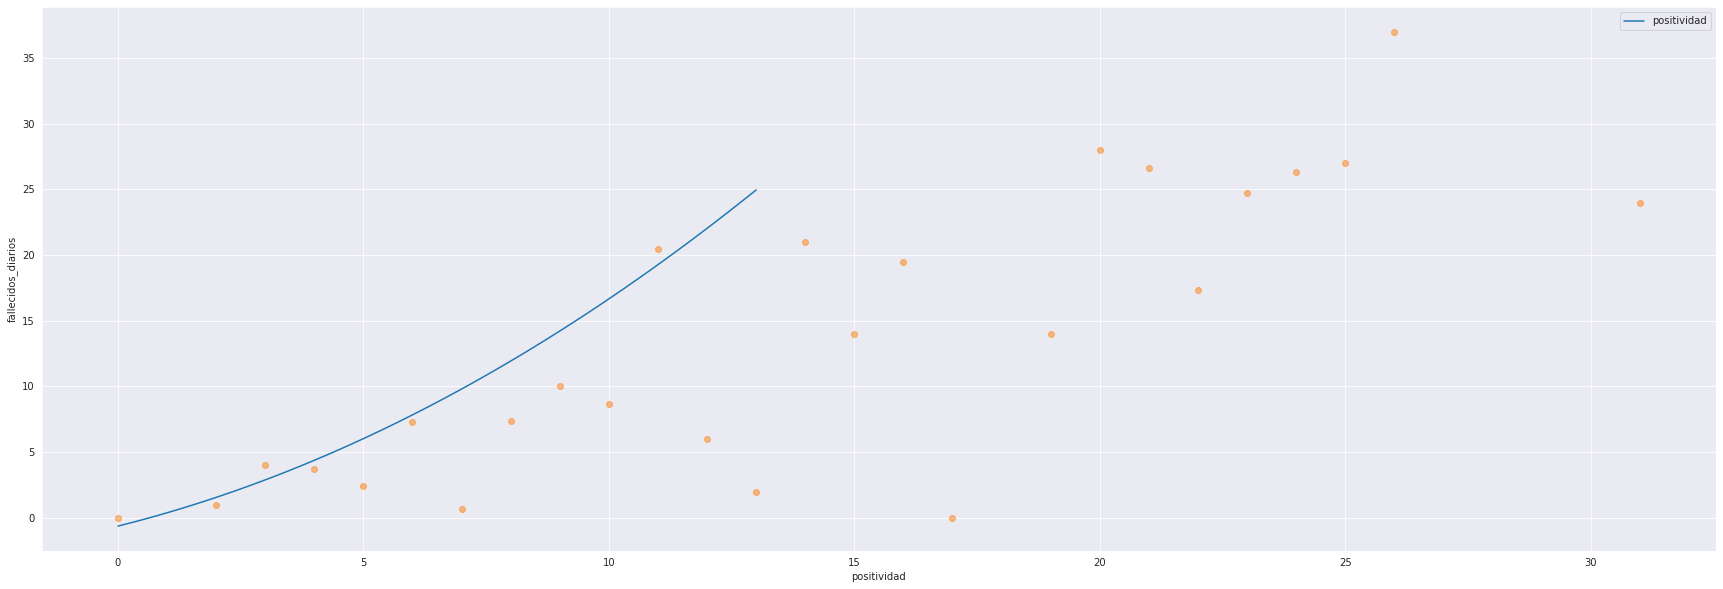

In [146]:
#plt.plot(df['dia'], pred12, label='dia')
plt.figure(figsize=(30,10))
plt.plot(df['positividad'], pred12, label='positividad')
plt.plot(mean_positividad_by_weekday, 'o', alpha=0.5)

#plt.xlabel('dia')
plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.legend()
plt.show()